# MANA Photosensitizer Property Prediction
## Complete Training Pipeline for Google Colab

This notebook contains the complete MANA training pipeline, including:
1. Google Drive mounting for data/model persistence
2. All model architecture code (PaiNN-based GNN)
3. Dataset loading and preprocessing
4. Training engine with LR scheduling
5. Two-phase training: Lambda (pre-training) → Phi (fine-tuning)

### Prerequisites
- Upload your `.h5` dataset files to Google Drive:
  - `lambdamax_data.h5`
  - `phi_data.h5`
- Set the `DRIVE_DATA_PATH` variable below to point to your data folder

---
## 1. Setup & Configuration

In [ ]:
# ============================================================================
# CONFIGURATION - Edit these paths to match your Google Drive structure
# ============================================================================

# Path to your data folder in Google Drive (relative to /content/drive/MyDrive/)
DRIVE_DATA_PATH = "MANA/data"

# Path where models will be saved in Google Drive
DRIVE_MODELS_PATH = "MANA/models"

# Dataset filenames
LAMBDA_DATASET_FILENAME = "lambda/lambda_all_data.h5"
FLUOR_DATASET_FILENAME = "fluor/fluorescence_data.h5"
PHI_DATASET_FILENAME = "phi/phidelta_data.h5"

# ============================================================================
# MODEL CONFIGURATION
# ============================================================================
# Universal atom type count - must be consistent across all training phases
# Set this to cover all atoms in BOTH datasets (e.g., 54 covers H through I)
NUM_ATOM_TYPES = 118

In [ ]:
# ============================================================================
# Mount Google Drive
# ============================================================================
from google.colab import drive
drive.mount('/content/drive')

import os
from pathlib import Path

# Build full paths
DRIVE_ROOT = Path("/content/drive/MyDrive")
DATA_DIR = DRIVE_ROOT / DRIVE_DATA_PATH
MODELS_DIR = DRIVE_ROOT / DRIVE_MODELS_PATH

LAMBDA_DATASET_PATH = DATA_DIR / LAMBDA_DATASET_FILENAME
FLUOR_DATASET_PATH = DATA_DIR / FLUOR_DATASET_FILENAME
PHI_DATASET_PATH = DATA_DIR / PHI_DATASET_FILENAME

# Create model directories
SAVE_DIR_LAMBDA = MODELS_DIR / "lambda"
SAVE_DIR_FLUOR = MODELS_DIR / "fluor"
SAVE_DIR_PHI = MODELS_DIR / "phi"
os.makedirs(SAVE_DIR_LAMBDA, exist_ok=True)
os.makedirs(SAVE_DIR_FLUOR, exist_ok=True)
os.makedirs(SAVE_DIR_PHI, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Lambda dataset: {LAMBDA_DATASET_PATH}")
print(f"Fluorescence dataset: {FLUOR_DATASET_PATH}")
print(f"Phi dataset: {PHI_DATASET_PATH}")
print()
print(f"Lambda dataset exists: {LAMBDA_DATASET_PATH.exists()}")
print(f"Fluorescence dataset exists: {FLUOR_DATASET_PATH.exists()}")
print(f"Phi dataset exists: {PHI_DATASET_PATH.exists()}")

Mounted at /content/drive
Data directory: /content/drive/MyDrive/MANA/data
Models directory: /content/drive/MyDrive/MANA/models
Lambda dataset: /content/drive/MyDrive/MANA/data/lambda/lambda_all_data.h5
Fluorescence dataset: /content/drive/MyDrive/MANA/data/fluor/fluorescence_data.h5
Phi dataset: /content/drive/MyDrive/MANA/data/phi/phidelta_data.h5

Lambda dataset exists: True
Fluorescence dataset exists: True
Phi dataset exists: True


In [ ]:
# ============================================================================
# Install Dependencies
# ============================================================================
!pip install torch-geometric h5py -q

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.4 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


---
## 2. Model Architecture (MANA with PaiNN)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


def scatter_sum(src, index, dim=-1, dim_size=None):
    """
    Native PyTorch implementation of scatter_sum to avoid torch_scatter dependency
    which often hangs on macOS (Apple Silicon).
    """
    if dim_size is None:
        dim_size = index.max().item() + 1

    # Create the output tensor of zeros
    size = list(src.size())
    size[dim] = dim_size
    out = torch.zeros(size, dtype=src.dtype, device=src.device)

    # index_add_ expects the index to have the same number of dimensions as src?
    # No, index_add_ expects a 1D index tensor.
    # We just need to ensure shapes match for the operation.
    return out.index_add_(dim, index, src)


class RadialBasisFunction(nn.Module):
    """
    Module to compute radial basis functions (RBFs) for given distances.
    Uses Gaussian RBFs centered at specified points with given widths.
    """

    def __init__(self, num_rbf, cutoff=5.0):
        """
        num_rbf: Number of radial basis functions.
        cutoff: Cutoff distance for the RBFs.
        """

        super().__init__()
        centers = torch.linspace(0.0, cutoff, num_rbf)
        self.register_buffer("centers", centers)
        self.gamma = nn.Parameter(torch.ones(num_rbf), requires_grad=False)

    def forward(self, distances):
        """
        Defines the forward pass to compute RBFs.
        distances: Tensor of shape (num_edges,) containing distances.
        Returns: Tensor of shape (num_edges, num_rbf) containing RBF values.
        """

        diff = distances.unsqueeze(-1) - self.centers
        return torch.exp(-self.gamma * diff**2)


class PaiNNLayer(nn.Module):
    """
    A single layer of the PaiNN architecture.
    """

    def __init__(self, hidden_dim, num_rbf):
        """
        Initializes the PaiNN layer.
        hidden_dim: Dimension of the hidden features.
        num_rbf: Number of radial basis functions.
        """

        super().__init__()

        self.filter_net = nn.Sequential(
            nn.Linear(num_rbf, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
        )

        self.update_net = nn.Sequential(
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 3 * hidden_dim),
        )

    def forward(self, s, v, edge_index, edge_attr, rbf):
        """
        PaiNN message passing with strict E(3)-equivariance.

        s: (N, F) scalar features
        v: (N, F, 3) vector features
        edge_index: (2, E)
        edge_attr: (E, 4) = (distance, dx, dy, dz)
        rbf: (E, num_rbf)
        """

        row, col = edge_index
        directions = edge_attr[:, 1:4]  # (E, 3)

        phi_ss, phi_vv, phi_sv = self.filter_net(rbf).chunk(3, dim=-1)

        m_s = phi_ss * s[col]
        m_v = phi_vv.unsqueeze(-1) * v[col] + phi_sv.unsqueeze(
            -1
        ) * directions.unsqueeze(1) * s[col].unsqueeze(-1)

        m_s = scatter_sum(m_s, row, dim=0, dim_size=s.size(0))
        m_v = scatter_sum(m_v, row, dim=0, dim_size=v.size(0))

        v_norm = torch.norm(m_v, dim=-1)
        delta_s, alpha, beta = self.update_net(
            torch.cat([s, m_s, v_norm], dim=-1)
        ).chunk(3, dim=-1)

        s = s + delta_s
        v = alpha.unsqueeze(-1) * v + beta.unsqueeze(-1) * m_v

        return s, v


class LambdaMaxHead(nn.Module):
    """
    Predicts absorption maximum (lambda_max) from molecular embedding
    """

    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )

    def forward(self, h_mol):
        """
        h_mol: (num_molecules, hidden_dim) molecular embeddings
        returns: (num_molecules, 1) lambda_max
        """
        return self.net(h_mol)


class PhiDeltaHead(nn.Module):
    """
    Predicts a singlet oxygen from molecular embedding
    """

    def __init__(self, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 1),
        )
        # Softplus followed by Sigmoid: Softplus avoids sharp negative saturation while
        # Sigmoid bounds the output to (0, 1) which helps prevent prediction clustering.
        self.activation = nn.Sigmoid()

    def forward(self, h_mol):
        """
        h_mol: (num_molecules, hidden_dim) molecular embeddings
        returns: (num_molecules, 1) singlet oxygen yield (non-negative, can exceed 1.0)
        """
        return self.activation(self.net(h_mol))


class MANA(nn.Module):
    def __init__(
        self,
        num_atom_types,
        hidden_dim=128,
        num_layers=4,
        num_rbf=20,
        tasks=None,
        lambda_mean=500.0,
        lambda_std=100.0,
    ):
        super().__init__()
        if tasks is None:
            tasks = ["lambda", "phi"]
        self.tasks = tasks

        self.embedding = nn.Embedding(num_atom_types, hidden_dim)
        self.rbf = RadialBasisFunction(num_rbf)
        self.layers = nn.ModuleList(
            [PaiNNLayer(hidden_dim, num_rbf) for _ in range(num_layers)]
        )

        combined_dim = hidden_dim * 3

        # Takes both the molecule embedding (hidden_dim) and the solvent embedding (hidden_dim)
        self.lambda_head = LambdaMaxHead(combined_dim)
        self.phi_head = PhiDeltaHead(combined_dim)

        self._init_weights()

        self.register_buffer("lambda_mean", torch.tensor(lambda_mean))
        self.register_buffer("lambda_std", torch.tensor(lambda_std))

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        if hasattr(self, "phi_head"):
            final_layer = self.phi_head.net[-1]
            if isinstance(final_layer, nn.Linear):
                nn.init.constant_(final_layer.bias, -2.0) # Sigmoid(-2.0) ≈ 0.12

    def _forward_graph(self, z, edge_index, edge_attr, batch, dim_size=None):
            """Runs the GNN backbone on a specific graph (Solute or Solvent)."""
            dist = edge_attr[:, 0]
            rbf = self.rbf(dist)

            s = self.embedding(z)
            v = torch.zeros(s.size(0), s.size(1), 3, device=s.device)

            for layer in self.layers:
                s, v = layer(s, v, edge_index, edge_attr, rbf)

            # Global Pooling -> (Batch, Hidden_Dim)
            # FIX 1: Pass dim_size to scatter_sum to ensure correct output size
            h = scatter_sum(s, batch, dim=0, dim_size=dim_size)

            # FIX 2: Ensure bincount matches the dim_size (batch size)
            if dim_size is not None:
                counts = torch.bincount(batch, minlength=dim_size)
            else:
                counts = torch.bincount(batch)

            h = h / (counts.unsqueeze(-1).float() + 1e-9)
            return h

    def forward(self, data):
        # 1. Process Solute (Always exists)
        h_mol = self._forward_graph(
            data.x, data.edge_index, data.edge_attr, data.batch
        )

        # Get the true batch size from the solute
        batch_size = h_mol.size(0)

        # 2. Process Solvent (Context)
        if hasattr(data, "x_s") and data.x_s.numel() > 0:
            # FIX 3: Pass batch_size (dim_size) to ensure alignment
            h_solv = self._forward_graph(
                data.x_s, data.edge_index_s, data.edge_attr_s, data.batch_s,
                dim_size=batch_size
            )
        else:
            # Zero padding for solvent if missing (Vacuum/Gas Phase)
            h_solv = torch.zeros_like(h_mol)

        h_mol = F.layer_norm(h_mol, h_mol.shape[1:])
        h_solv = F.layer_norm(h_solv, h_solv.shape[1:])

        # 3. Concatenate (Solute + Solvent)
        h_combined = torch.cat([h_mol, h_solv, h_mol * h_solv], dim=1)

        results = {}

        if "lambda" in self.tasks:
            results["lambda"] = self.lambda_head(h_combined).squeeze(-1)

        if "phi" in self.tasks:
            results["phi"] = self.phi_head(h_combined).squeeze(-1)

        return results

    def loss_fn(self, preds, batch):
        """
        Defines the loss function for training.
        """
        loss = 0
        metrics = {}

        if "lambda" in self.tasks and hasattr(batch, "lambda_max"):
            mask = torch.isfinite(batch.lambda_max.squeeze())
            if mask.any():
                pred_norm = (preds["lambda"][mask] - self.lambda_mean) / self.lambda_std
                target_norm = (
                    batch.lambda_max[mask] - self.lambda_mean
                ) / self.lambda_std

                loss_lambda = F.huber_loss(pred_norm, target_norm, delta=1.0)
                loss += loss_lambda
                metrics["loss_lambda"] = loss_lambda.item()

        if "phi" in self.tasks and hasattr(batch, "phi_delta"):
            mask = torch.isfinite(batch.phi_delta.squeeze())
            if mask.any():
                loss_phi = F.huber_loss(
                    preds["phi"][mask], batch.phi_delta[mask], delta=0.5
                )
                loss += 5 * loss_phi
                metrics["loss_phi"] = loss_phi.item()

        return loss, metrics

    def freeze_backbone(self, heads):
        for param in self.parameters():
            param.requires_grad = False

        if "lambda" in heads:
            for param in self.lambda_head.parameters():
                param.requires_grad = True
        if "phi" in heads:
            for param in self.phi_head.parameters():
                param.requires_grad = True
        print(f"✓ Backbone frozen. {heads} head is trainable.")

---
## 3. Dataset Loading

In [ ]:
# ============================================================================
# Dataset Constructor
# ============================================================================

import h5py
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm

class PairData(Data):
    """
    Custom PyG Data object to handle two disjoint graphs (Solute + Solvent).
    This tells the DataLoader how to increment indices when stacking batches.
    """
    def __inc__(self, key, value, *args, **kwargs):
        if key == 'edge_index_s':
            # Increment solvent edge indices by the number of solvent nodes in the batch so far
            return self.x_s.size(0)
        if key == 'batch_s':
            # Increment the graph index for the solvent batch vector
            return 1
        return super().__inc__(key, value, *args, **kwargs)

class GeometricSubset:
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

class DatasetConstructor(Dataset):
    def __init__(
        self,
        hdf5_file,
        cutoff_radius=5.0,
        batch_size=32,
        train_split=0.8,
        val_split=0.1,
        random_seed=42,
        num_atom_types=None,
        split_by_mol_id=False,
    ):
        super().__init__()

        self.cutoff_radius = cutoff_radius
        self.batch_size = batch_size

        print(f"Loading data from {hdf5_file}...")
        with h5py.File(hdf5_file, "r") as f:
            # Solute Data
            self.atomic_numbers = f["atomic_numbers"][()]
            self.positions = f["geometries"][()]

            # Solvent Data (Optional, but required for Phi models)
            if "solvent_atomic_numbers" in f:
                self.solvent_atomic_numbers = f["solvent_atomic_numbers"][()]
                self.solvent_positions = f["solvent_geometries"][()]
                self.has_solvent = True
            else:
                self.has_solvent = False

            # Targets
            self.lambda_max = f["lambda_max"][()]
            self.phi_delta = f["phi_delta"][()]
            self.mol_ids = f["mol_ids"][()]

            raw_smiles = f["smiles"][()]
            self.smiles = [s.decode("utf-8") if isinstance(s, bytes) else s for s in raw_smiles]

        # Build Vocabulary (Unified for both solute and solvent)
        unique_atoms = set()
        for z in self.atomic_numbers:
            unique_atoms.update(z[z > 0])

        if self.has_solvent:
            for z in self.solvent_atomic_numbers:
                unique_atoms.update(z[z > 0])

        self.unique_atoms = sorted(list(unique_atoms))
        self.atom_to_index = {a: i + 1 for i, a in enumerate(self.unique_atoms)}

        self.n_structures = self.atomic_numbers.shape[0]

        # PRE-COMPUTE GRAPHS
        print(f"Pre-processing {self.n_structures} graphs...")
        self.data_list = []
        for idx in tqdm(range(self.n_structures)):
            self.data_list.append(self._process_one(idx))

        # Create Splits
        np.random.seed(random_seed)
        if split_by_mol_id:
            unique_mol_ids = np.unique(self.mol_ids)
            np.random.shuffle(unique_mol_ids)
            n_mol_train = int(train_split * len(unique_mol_ids))
            n_mol_val = int(val_split * len(unique_mol_ids))

            train_ids = set(unique_mol_ids[:n_mol_train])
            val_ids = set(unique_mol_ids[n_mol_train : n_mol_train + n_mol_val])

            self.train_indices = [i for i in range(self.n_structures) if self.mol_ids[i] in train_ids]
            self.val_indices = [i for i in range(self.n_structures) if self.mol_ids[i] in val_ids]
            self.test_indices = [i for i in range(self.n_structures) if self.mol_ids[i] not in train_ids and self.mol_ids[i] not in val_ids]
        else:
            idx = np.random.permutation(self.n_structures)
            n_train = int(train_split * self.n_structures)
            n_val = int(val_split * self.n_structures)
            self.train_indices = idx[:n_train]
            self.val_indices = idx[n_train : n_train + n_val]
            self.test_indices = idx[n_train + n_val :]

        # Stats
        train_lambda = self.lambda_max[self.train_indices]
        self.lambda_mean = np.mean(train_lambda)
        self.lambda_std = np.std(train_lambda)

    def _tensor_from_raw(self, z_raw, pos_raw):
        """Helper to create graph tensors from raw arrays"""
        z = torch.tensor([self.atom_to_index.get(a, 0) for a in z_raw], dtype=torch.long)
        pos = torch.tensor(pos_raw, dtype=torch.float32)

        # Remove padding
        mask = z > 0
        z = z[mask]
        pos = pos[mask]

        if pos.size(0) == 0:
            return z, pos, torch.empty((2, 0), dtype=torch.long), torch.empty((0, 4))

        dist = torch.cdist(pos, pos)
        mask = (dist < self.cutoff_radius) & (dist > 0)
        row, col = mask.nonzero(as_tuple=True)
        edge_index = torch.stack([row, col], dim=0)

        diff = pos[col] - pos[row]
        d = torch.norm(diff, dim=1, keepdim=True)
        u = diff / (d + 1e-8)
        edge_attr = torch.cat([d, u], dim=1)

        return z, pos, edge_index, edge_attr

    def _process_one(self, idx):
        # 1. Process Solute
        z, pos, edge_index, edge_attr = self._tensor_from_raw(
            self.atomic_numbers[idx], self.positions[idx]
        )

        # 2. Process Solvent (if available)
        if self.has_solvent:
            z_s, pos_s, edge_index_s, edge_attr_s = self._tensor_from_raw(
                self.solvent_atomic_numbers[idx], self.solvent_positions[idx]
            )
            # Create a batch vector for the solvent (all zeros for a single graph)
            # DataLoader will stack these. PairData.__inc__ handles the graph index increment.
            batch_s = torch.zeros(z_s.size(0), dtype=torch.long)
        else:
            # Dummy solvent data to prevent crashes if loading non-solvent datasets
            z_s = torch.tensor([], dtype=torch.long)
            pos_s = torch.tensor([], dtype=torch.float32)
            edge_index_s = torch.empty((2, 0), dtype=torch.long)
            edge_attr_s = torch.empty((0, 4))
            batch_s = torch.tensor([], dtype=torch.long)

        # 3. Create PairData Object
        return PairData(
            # Solute
            x=z,
            pos=pos,
            edge_index=edge_index,
            edge_attr=edge_attr,

            # Solvent (Suffix _s)
            x_s=z_s,
            pos_s=pos_s,
            edge_index_s=edge_index_s,
            edge_attr_s=edge_attr_s,
            batch_s=batch_s,

            # Targets
            lambda_max=torch.tensor([self.lambda_max[idx]], dtype=torch.float32),
            phi_delta=torch.tensor([self.phi_delta[idx]], dtype=torch.float32),
            mol_id=torch.tensor([self.mol_ids[idx]], dtype=torch.int32),
            smiles=self.smiles[idx],
        )

    def len(self):
        return self.n_structures

    def get(self, idx):
        return self.data_list[idx]

    def __getitem__(self, idx):
        return self.data_list[idx]

    def get_dataloaders(self, num_workers=0):
        return (
            DataLoader(GeometricSubset(self, self.train_indices), batch_size=self.batch_size, shuffle=True, num_workers=num_workers),
            DataLoader(GeometricSubset(self, self.val_indices), batch_size=self.batch_size, shuffle=False, num_workers=num_workers),
            DataLoader(GeometricSubset(self, self.test_indices), batch_size=self.batch_size, shuffle=False, num_workers=num_workers),
        )


print("✓ Dataset constructor loaded")

✓ Dataset constructor loaded


---
## 4. Training Engine

In [ ]:
# ============================================================================
# Training Engine
# ============================================================================

import os

import matplotlib
import numpy as np
import torch
from torch.optim.adam import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

# Use non-interactive backend so training on headless machines works
matplotlib.use("Agg")
import matplotlib.pyplot as plt


class TrainingEngine:
    def __init__(
        self,
        model,
        device,
        train_loader,
        val_loader,
        hyperparams,
        save_dir,
    ):
        self.model = model.to(device)
        self.device = device
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.save_dir = save_dir

        self.max_epochs = hyperparams["max_epochs"]
        self.patience = hyperparams["early_stopping_patience"]

        # Only optimize parameters that require gradients (supports frozen backbone)
        self.optimizer = Adam(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=hyperparams["learning_rate"],
            weight_decay=hyperparams["weight_decay"],
        )

        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=0.5,
            patience=20,
            min_lr=1e-6,
        )

        os.makedirs(save_dir, exist_ok=True)

        # History for plotting and analysis
        self.history = {
            "train_total": [],
            "val_total": [],
            "train_lambda": [],
            "train_phi": [],
            "val_lambda": [],
            "val_phi": [],
        }

    def train(self):
        best_val = float("inf")
        patience_counter = 0

        for epoch in range(1, self.max_epochs + 1):
            train_total, train_comps = self._train_epoch()
            val_total, val_comps = self._validate()

            # store history
            self.history["train_total"].append(train_total)
            self.history["val_total"].append(val_total)

            self.history["train_lambda"].append(train_comps.get("loss_lambda", 0))
            self.history["train_phi"].append(train_comps.get("loss_phi", 0))
            self.history["val_lambda"].append(val_comps.get("loss_lambda", 0))
            self.history["val_phi"].append(val_comps.get("loss_phi", 0))

            # Step the learning rate scheduler
            self.scheduler.step(val_total)

            # Print totals and components for transparency
            current_lr = self.optimizer.param_groups[0]["lr"]
            lam_str = f"λ={train_comps.get('loss_lambda', 0):.2f}"
            phi_str = f"φ={train_comps.get('loss_phi', 0):.4f}"

            val_lam_str = f"λ={val_comps.get('loss_lambda', 0):.2f}"
            val_phi_str = f"φ={val_comps.get('loss_phi', 0):.4f}"

            print(
                f"Epoch {epoch:4d} | "
                f"Train: {train_total:.4f} ({lam_str}, {phi_str}) | "
                f"Val: {val_total:.4f} ({val_lam_str}, {val_phi_str}) | "
                f"LR: {current_lr:.2e}"
            )

            # checkpointing based on validation total loss
            if val_total < best_val:
                best_val = val_total
                patience_counter = 0
                torch.save(
                    self.model.state_dict(),
                    os.path.join(self.save_dir, "best_model.pth"),
                )
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print("Early stopping triggered.")
                break

        # After training, save and plot loss curves
        try:
            self._plot_losses()
            print(f"Saved loss history and plots to: {self.save_dir}")
        except Exception as e:
            # don't crash training if plotting fails; just report
            print(f"Warning: failed to save/plot losses: {e}")

    def _train_epoch(self):
        self.model.train()
        total_loss = 0.0
        accumulators = {}
        n_batches = 0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)

        for i, batch in enumerate(pbar):
            batch = batch.to(self.device)

            preds = self.model(batch)

            loss, metrics = self.model.loss_fn(preds, batch)

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()

            total_loss += loss.item()
            for k, v in metrics.items():
                accumulators[k] = accumulators.get(k, 0.0) + v
            n_batches += 1

            current_lam = metrics.get("loss_lambda", 0.0)
            current_phi = metrics.get("loss_phi", 0.0)
            pbar.set_postfix(
                {
                    "Loss": f"{loss.item():.2f}",
                    "λ": f"{current_lam:.1f}",
                    "φ": f"{current_phi:.4f}",
                }
            )

        if n_batches == 0:
            return 0.0, {}

        self._save_history()

        avg_metrics = {k: v / n_batches for k, v in accumulators.items()}
        return total_loss / n_batches, avg_metrics

    @torch.no_grad()
    def _validate(self):
        self.model.eval()

        total_loss = 0.0

        accumulators = {}

        n_batches = 0

        for batch in self.val_loader:
            batch = batch.to(self.device)
            preds = self.model(batch)
            loss, metrics = self.model.loss_fn(preds, batch)

            total_loss += loss.item()

            for k, v in metrics.items():
                accumulators[k] = accumulators.get(k, 0.0) + v

            n_batches += 1

        if n_batches == 0:
            return 0.0, {}

        self._save_history()

        # Average out
        avg_metrics = {k: v / n_batches for k, v in accumulators.items()}
        return total_loss / n_batches, avg_metrics

    def _save_history(self):
        # Convert lists to numpy arrays and save
        save_dict = {k: np.array(v) for k, v in self.history.items()}
        np.savez_compressed(
            os.path.join(self.save_dir, "loss_history.npz"),
            **save_dict,  # pyright:ignore[reportArgumentType]
        )

    def _plot_losses(self):
        epochs = np.arange(1, len(self.history["train_total"]) + 1)

        # Create 2 subplots so the scales don't mess each other up
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot 1: Lambda Max (High values)
        ax1.plot(
            epochs,
            self.history["train_lambda"],
            label="Train Lambda",
            color="tab:purple",
        )
        ax1.plot(
            epochs,
            self.history["val_lambda"],
            "--",
            label="Val Lambda",
            color="tab:purple",
        )
        ax1.set_title("Absorption (Lambda) Loss")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Huber Loss")
        ax1.legend()
        ax1.grid(True)

        # Plot 2: Phi (Low values)
        ax2.plot(
            epochs, self.history["train_phi"], label="Train Phi", color="tab:brown"
        )
        ax2.plot(
            epochs, self.history["val_phi"], "--", label="Val Phi", color="tab:brown"
        )
        ax2.set_title("Quantum Yield (Phi) Loss")
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("Huber Loss")
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()

        # FIX: Just use a relative filename. It will save inside self.save_dir automatically.
        fig_path = os.path.join(self.save_dir, "loss_curves.png")
        plt.savefig(fig_path)
        plt.close()


print("✓ Training engine loaded")

✓ Training engine loaded


---
## 5.Training

In [ ]:
def train_phase(phase_name, hyperparams, dataset_path, save_dir, load_path=None, freeze_backbone=False):
    print("\n" + "=" * 80)
    print(f"STARTING PHASE: {phase_name.upper()}")
    print("=" * 80)
    print(f"Primary Dataset: {dataset_path}")

    print(f"Tasks: {hyperparams['tasks']}")

    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset not found at {dataset_path}")
        return

    # 1. Load Primary Dataset
    dataset = DatasetConstructor(
        str(dataset_path),
        cutoff_radius=5.0,
        batch_size=64,
        train_split=0.8,
        val_split=0.1,
        random_seed=42,
        split_by_mol_id=True,
    )

    train_set = dataset.get_dataloaders(num_workers=0)[0].dataset
    val_set = dataset.get_dataloaders(num_workers=0)[1].dataset

    # Re-wrap in DataLoaders
    from torch_geometric.loader import DataLoader
    train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=0)

    # Handle Normalization Stats (Use primary dataset stats)
    l_mean = dataset.lambda_mean if not np.isnan(dataset.lambda_mean) else 500.0
    l_std = dataset.lambda_std if not np.isnan(dataset.lambda_std) else 100.0

    # 3. Model
    model = MANA(
        num_atom_types=NUM_ATOM_TYPES,
        hidden_dim=128,
        num_layers=4,
        num_rbf=20,
        tasks=hyperparams["tasks"],
        lambda_mean=l_mean,
        lambda_std=l_std,
    )

    # 4. Load Weights
    if load_path:
        print(f"Loading weights from: {load_path}")
        model.load_state_dict(torch.load(load_path, map_location='cpu'), strict=False)

    if freeze_backbone:
        model.freeze_backbone(hyperparams["tasks"])

    # 5. Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.backends.mps.is_available(): device = torch.device("mps")
    model = model.to(device)

    # 6. Train
    engine = TrainingEngine(
        model=model,
        device=device,
        train_loader=train_loader,
        val_loader=val_loader,
        hyperparams=hyperparams,
        save_dir=str(save_dir),
    )

    engine.train()
    print(f"\n{phase_name} complete. Best model saved to {save_dir}/best_model.pth")

In [ ]:
# =================================================================
# PHASE 1: Pretraining (Fluorescence)
# Objective: Learn emission physics (Phi_F) while learning absorption.
# =================================================================
p1_params = {
    "learning_rate": 1e-3, # Lower LR to refine
    "max_epochs": 200,
    "early_stopping_patience": 40,
    "weight_decay": 1e-5,
    "tasks": ["lambda", "phi"], # Train BOTH heads
}

train_phase("Phase 1 (Fluorescence)", p1_params, FLUOR_DATASET_PATH, SAVE_DIR_FLUOR)



STARTING PHASE: PHASE 1 (FLUORESCENCE)
Primary Dataset: /content/drive/MyDrive/MANA/data/fluor/fluorescence_data.h5
Tasks: ['lambda', 'phi']
Loading data from /content/drive/MyDrive/MANA/data/fluor/fluorescence_data.h5...
Pre-processing 12333 graphs...


100%|██████████| 12333/12333 [00:13<00:00, 921.72it/s]


Epoch    1 | Train: 0.9560 (λ=0.71, φ=0.0490) | Val: 0.5141 (λ=0.28, φ=0.0474) | LR: 1.00e-03


Epoch    2 | Train: 0.4285 (λ=0.20, φ=0.0454) | Val: 0.4078 (λ=0.17, φ=0.0474) | LR: 1.00e-03


Epoch    3 | Train: 0.3640 (λ=0.14, φ=0.0448) | Val: 0.3837 (λ=0.14, φ=0.0482) | LR: 1.00e-03


Epoch    4 | Train: 0.3113 (λ=0.11, φ=0.0397) | Val: 0.2922 (λ=0.11, φ=0.0365) | LR: 1.00e-03


Epoch    5 | Train: 0.2605 (λ=0.09, φ=0.0337) | Val: 0.2381 (λ=0.08, φ=0.0313) | LR: 1.00e-03


Epoch    6 | Train: 0.2241 (λ=0.08, φ=0.0293) | Val: 0.2372 (λ=0.09, φ=0.0293) | LR: 1.00e-03


Epoch    7 | Train: 0.2000 (λ=0.07, φ=0.0259) | Val: 0.2670 (λ=0.13, φ=0.0284) | LR: 1.00e-03


Epoch    8 | Train: 0.1802 (λ=0.06, φ=0.0236) | Val: 0.1981 (λ=0.07, φ=0.0258) | LR: 1.00e-03


Epoch    9 | Train: 0.1608 (λ=0.05, φ=0.0213) | Val: 0.2137 (λ=0.08, φ=0.0274) | LR: 1.00e-03


Epoch   10 | Train: 0.1532 (λ=0.05, φ=0.0202) | Val: 0.1839 (λ=0.06, φ=0.0251) | LR: 1.00e-03


Epoch   11 | Train: 0.1384 (λ=0.05, φ=0.0183) | Val: 0.1815 (λ=0.06, φ=0.0244) | LR: 1.00e-03


Epoch   12 | Train: 0.1311 (λ=0.04, φ=0.0173) | Val: 0.2171 (λ=0.10, φ=0.0225) | LR: 1.00e-03


Epoch   13 | Train: 0.1200 (λ=0.04, φ=0.0159) | Val: 0.1871 (λ=0.07, φ=0.0241) | LR: 1.00e-03


Epoch   14 | Train: 0.1146 (λ=0.04, φ=0.0157) | Val: 0.1924 (λ=0.05, φ=0.0287) | LR: 1.00e-03


Epoch   15 | Train: 0.1095 (λ=0.04, φ=0.0148) | Val: 0.1524 (λ=0.05, φ=0.0210) | LR: 1.00e-03


Epoch   16 | Train: 0.1011 (λ=0.03, φ=0.0134) | Val: 0.1687 (λ=0.06, φ=0.0220) | LR: 1.00e-03


Epoch   17 | Train: 0.0968 (λ=0.03, φ=0.0129) | Val: 0.1524 (λ=0.05, φ=0.0212) | LR: 1.00e-03


Epoch   18 | Train: 0.0921 (λ=0.03, φ=0.0123) | Val: 0.1536 (λ=0.05, φ=0.0207) | LR: 1.00e-03


Epoch   19 | Train: 0.0848 (λ=0.03, φ=0.0110) | Val: 0.1551 (λ=0.05, φ=0.0207) | LR: 1.00e-03


Epoch   20 | Train: 0.0840 (λ=0.03, φ=0.0112) | Val: 0.1377 (λ=0.04, φ=0.0190) | LR: 1.00e-03


Epoch   21 | Train: 0.0799 (λ=0.03, φ=0.0101) | Val: 0.1378 (λ=0.04, φ=0.0186) | LR: 1.00e-03


Epoch   22 | Train: 0.0789 (λ=0.03, φ=0.0103) | Val: 0.1471 (λ=0.05, φ=0.0197) | LR: 1.00e-03


Epoch   23 | Train: 0.0719 (λ=0.03, φ=0.0092) | Val: 0.1506 (λ=0.06, φ=0.0183) | LR: 1.00e-03


Epoch   24 | Train: 0.0720 (λ=0.03, φ=0.0092) | Val: 0.1344 (λ=0.04, φ=0.0189) | LR: 1.00e-03


Epoch   25 | Train: 0.0650 (λ=0.02, φ=0.0084) | Val: 0.1341 (λ=0.04, φ=0.0181) | LR: 1.00e-03


Epoch   26 | Train: 0.0671 (λ=0.03, φ=0.0084) | Val: 0.1297 (λ=0.04, φ=0.0184) | LR: 1.00e-03


Epoch   27 | Train: 0.0636 (λ=0.02, φ=0.0084) | Val: 0.1314 (λ=0.04, φ=0.0182) | LR: 1.00e-03


Epoch   28 | Train: 0.0642 (λ=0.02, φ=0.0081) | Val: 0.1522 (λ=0.05, φ=0.0208) | LR: 1.00e-03


Epoch   29 | Train: 0.0595 (λ=0.02, φ=0.0076) | Val: 0.1314 (λ=0.04, φ=0.0183) | LR: 1.00e-03


Epoch   30 | Train: 0.0593 (λ=0.02, φ=0.0074) | Val: 0.1353 (λ=0.04, φ=0.0193) | LR: 1.00e-03


Epoch   31 | Train: 0.0589 (λ=0.02, φ=0.0075) | Val: 0.1484 (λ=0.05, φ=0.0196) | LR: 1.00e-03


Epoch   32 | Train: 0.0544 (λ=0.02, φ=0.0068) | Val: 0.1263 (λ=0.04, φ=0.0163) | LR: 1.00e-03


Epoch   33 | Train: 0.0525 (λ=0.02, φ=0.0065) | Val: 0.1412 (λ=0.05, φ=0.0189) | LR: 1.00e-03


Epoch   34 | Train: 0.0507 (λ=0.02, φ=0.0063) | Val: 0.1151 (λ=0.03, φ=0.0163) | LR: 1.00e-03


Epoch   35 | Train: 0.0509 (λ=0.02, φ=0.0063) | Val: 0.1255 (λ=0.04, φ=0.0172) | LR: 1.00e-03


Epoch   36 | Train: 0.0501 (λ=0.02, φ=0.0062) | Val: 0.1215 (λ=0.03, φ=0.0175) | LR: 1.00e-03


Epoch   37 | Train: 0.0501 (λ=0.02, φ=0.0062) | Val: 0.1165 (λ=0.04, φ=0.0162) | LR: 1.00e-03


Epoch   38 | Train: 0.0480 (λ=0.02, φ=0.0058) | Val: 0.1263 (λ=0.04, φ=0.0179) | LR: 1.00e-03


Epoch   39 | Train: 0.0473 (λ=0.02, φ=0.0057) | Val: 0.1234 (λ=0.03, φ=0.0181) | LR: 1.00e-03


Epoch   40 | Train: 0.0441 (λ=0.02, φ=0.0055) | Val: 0.1186 (λ=0.04, φ=0.0167) | LR: 1.00e-03


Epoch   41 | Train: 0.0485 (λ=0.02, φ=0.0058) | Val: 0.1214 (λ=0.04, φ=0.0170) | LR: 1.00e-03


Epoch   42 | Train: 0.0443 (λ=0.02, φ=0.0052) | Val: 0.1166 (λ=0.03, φ=0.0165) | LR: 1.00e-03


Epoch   43 | Train: 0.0424 (λ=0.02, φ=0.0051) | Val: 0.1363 (λ=0.04, φ=0.0185) | LR: 1.00e-03


Epoch   44 | Train: 0.0432 (λ=0.02, φ=0.0051) | Val: 0.1159 (λ=0.04, φ=0.0159) | LR: 1.00e-03


Epoch   45 | Train: 0.0406 (λ=0.02, φ=0.0048) | Val: 0.1387 (λ=0.05, φ=0.0187) | LR: 1.00e-03


Epoch   46 | Train: 0.0410 (λ=0.02, φ=0.0050) | Val: 0.1156 (λ=0.03, φ=0.0169) | LR: 1.00e-03


Epoch   47 | Train: 0.0421 (λ=0.02, φ=0.0051) | Val: 0.1164 (λ=0.03, φ=0.0173) | LR: 1.00e-03


Epoch   48 | Train: 0.0436 (λ=0.02, φ=0.0053) | Val: 0.1203 (λ=0.03, φ=0.0171) | LR: 1.00e-03


Epoch   49 | Train: 0.0404 (λ=0.02, φ=0.0048) | Val: 0.1277 (λ=0.04, φ=0.0169) | LR: 1.00e-03


Epoch   50 | Train: 0.0439 (λ=0.02, φ=0.0050) | Val: 0.1246 (λ=0.04, φ=0.0172) | LR: 1.00e-03


Epoch   51 | Train: 0.0409 (λ=0.02, φ=0.0046) | Val: 0.1247 (λ=0.04, φ=0.0166) | LR: 1.00e-03


Epoch   52 | Train: 0.0374 (λ=0.02, φ=0.0042) | Val: 0.1175 (λ=0.03, φ=0.0168) | LR: 1.00e-03


Epoch   53 | Train: 0.0381 (λ=0.02, φ=0.0044) | Val: 0.1182 (λ=0.03, φ=0.0172) | LR: 1.00e-03


Epoch   54 | Train: 0.0346 (λ=0.02, φ=0.0039) | Val: 0.1178 (λ=0.03, φ=0.0175) | LR: 1.00e-03


Epoch   55 | Train: 0.0363 (λ=0.02, φ=0.0042) | Val: 0.1172 (λ=0.03, φ=0.0176) | LR: 5.00e-04


Epoch   56 | Train: 0.0267 (λ=0.01, φ=0.0030) | Val: 0.1059 (λ=0.03, φ=0.0157) | LR: 5.00e-04


Epoch   57 | Train: 0.0226 (λ=0.01, φ=0.0025) | Val: 0.1034 (λ=0.03, φ=0.0152) | LR: 5.00e-04


Epoch   58 | Train: 0.0222 (λ=0.01, φ=0.0024) | Val: 0.1032 (λ=0.03, φ=0.0150) | LR: 5.00e-04


Epoch   59 | Train: 0.0214 (λ=0.01, φ=0.0022) | Val: 0.1067 (λ=0.03, φ=0.0157) | LR: 5.00e-04


Epoch   60 | Train: 0.0213 (λ=0.01, φ=0.0023) | Val: 0.1072 (λ=0.03, φ=0.0161) | LR: 5.00e-04


Epoch   61 | Train: 0.0209 (λ=0.01, φ=0.0022) | Val: 0.1089 (λ=0.03, φ=0.0161) | LR: 5.00e-04


Epoch   62 | Train: 0.0207 (λ=0.01, φ=0.0021) | Val: 0.1089 (λ=0.03, φ=0.0160) | LR: 5.00e-04


Epoch   63 | Train: 0.0209 (λ=0.01, φ=0.0022) | Val: 0.1080 (λ=0.03, φ=0.0157) | LR: 5.00e-04


Epoch   64 | Train: 0.0204 (λ=0.01, φ=0.0021) | Val: 0.1088 (λ=0.03, φ=0.0157) | LR: 5.00e-04


Epoch   65 | Train: 0.0203 (λ=0.01, φ=0.0021) | Val: 0.1079 (λ=0.03, φ=0.0159) | LR: 5.00e-04


Epoch   66 | Train: 0.0207 (λ=0.01, φ=0.0022) | Val: 0.1087 (λ=0.03, φ=0.0161) | LR: 5.00e-04


Epoch   67 | Train: 0.0212 (λ=0.01, φ=0.0022) | Val: 0.1165 (λ=0.03, φ=0.0168) | LR: 5.00e-04


Epoch   68 | Train: 0.0207 (λ=0.01, φ=0.0021) | Val: 0.1111 (λ=0.03, φ=0.0163) | LR: 5.00e-04


Epoch   69 | Train: 0.0208 (λ=0.01, φ=0.0021) | Val: 0.1101 (λ=0.03, φ=0.0157) | LR: 5.00e-04


Epoch   70 | Train: 0.0201 (λ=0.01, φ=0.0020) | Val: 0.1090 (λ=0.03, φ=0.0160) | LR: 5.00e-04


Epoch   71 | Train: 0.0212 (λ=0.01, φ=0.0021) | Val: 0.1092 (λ=0.03, φ=0.0160) | LR: 5.00e-04


Epoch   72 | Train: 0.0192 (λ=0.01, φ=0.0020) | Val: 0.1074 (λ=0.03, φ=0.0160) | LR: 5.00e-04


Epoch   73 | Train: 0.0191 (λ=0.01, φ=0.0019) | Val: 0.1093 (λ=0.03, φ=0.0153) | LR: 5.00e-04


Epoch   74 | Train: 0.0200 (λ=0.01, φ=0.0020) | Val: 0.1109 (λ=0.03, φ=0.0165) | LR: 5.00e-04


Epoch   75 | Train: 0.0191 (λ=0.01, φ=0.0019) | Val: 0.1119 (λ=0.03, φ=0.0163) | LR: 5.00e-04


Epoch   76 | Train: 0.0190 (λ=0.01, φ=0.0019) | Val: 0.1090 (λ=0.03, φ=0.0160) | LR: 5.00e-04


Epoch   77 | Train: 0.0190 (λ=0.01, φ=0.0019) | Val: 0.1112 (λ=0.03, φ=0.0166) | LR: 5.00e-04


Epoch   78 | Train: 0.0190 (λ=0.01, φ=0.0018) | Val: 0.1139 (λ=0.03, φ=0.0166) | LR: 5.00e-04


Epoch   79 | Train: 0.0207 (λ=0.01, φ=0.0022) | Val: 0.1044 (λ=0.03, φ=0.0151) | LR: 2.50e-04


Epoch   80 | Train: 0.0155 (λ=0.01, φ=0.0015) | Val: 0.1049 (λ=0.03, φ=0.0154) | LR: 2.50e-04


Epoch   81 | Train: 0.0133 (λ=0.01, φ=0.0012) | Val: 0.1051 (λ=0.03, φ=0.0156) | LR: 2.50e-04


Epoch   82 | Train: 0.0127 (λ=0.01, φ=0.0011) | Val: 0.1067 (λ=0.03, φ=0.0158) | LR: 2.50e-04


Epoch   83 | Train: 0.0128 (λ=0.01, φ=0.0011) | Val: 0.1048 (λ=0.03, φ=0.0154) | LR: 2.50e-04


Epoch   84 | Train: 0.0126 (λ=0.01, φ=0.0011) | Val: 0.1042 (λ=0.03, φ=0.0152) | LR: 2.50e-04


Epoch   85 | Train: 0.0125 (λ=0.01, φ=0.0011) | Val: 0.1037 (λ=0.03, φ=0.0155) | LR: 2.50e-04


Epoch   86 | Train: 0.0129 (λ=0.01, φ=0.0011) | Val: 0.1074 (λ=0.03, φ=0.0155) | LR: 2.50e-04


Epoch   87 | Train: 0.0132 (λ=0.01, φ=0.0011) | Val: 0.1043 (λ=0.03, φ=0.0154) | LR: 2.50e-04


Epoch   88 | Train: 0.0128 (λ=0.01, φ=0.0011) | Val: 0.1041 (λ=0.03, φ=0.0151) | LR: 2.50e-04


Epoch   89 | Train: 0.0127 (λ=0.01, φ=0.0011) | Val: 0.1065 (λ=0.03, φ=0.0158) | LR: 2.50e-04


Epoch   90 | Train: 0.0125 (λ=0.01, φ=0.0010) | Val: 0.1087 (λ=0.03, φ=0.0157) | LR: 2.50e-04


Epoch   91 | Train: 0.0125 (λ=0.01, φ=0.0011) | Val: 0.1041 (λ=0.03, φ=0.0155) | LR: 2.50e-04


Epoch   92 | Train: 0.0124 (λ=0.01, φ=0.0011) | Val: 0.1082 (λ=0.03, φ=0.0161) | LR: 2.50e-04


Epoch   93 | Train: 0.0125 (λ=0.01, φ=0.0010) | Val: 0.1061 (λ=0.03, φ=0.0157) | LR: 2.50e-04


Epoch   94 | Train: 0.0123 (λ=0.01, φ=0.0011) | Val: 0.1044 (λ=0.03, φ=0.0156) | LR: 2.50e-04


Epoch   95 | Train: 0.0122 (λ=0.01, φ=0.0010) | Val: 0.1080 (λ=0.03, φ=0.0157) | LR: 2.50e-04


Epoch   96 | Train: 0.0122 (λ=0.01, φ=0.0010) | Val: 0.1044 (λ=0.03, φ=0.0151) | LR: 2.50e-04


Epoch   97 | Train: 0.0119 (λ=0.01, φ=0.0010) | Val: 0.1047 (λ=0.03, φ=0.0155) | LR: 2.50e-04


Epoch   98 | Train: 0.0117 (λ=0.01, φ=0.0010) | Val: 0.1040 (λ=0.03, φ=0.0154) | LR: 2.50e-04
Early stopping triggered.
Saved loss history and plots to: /content/drive/MyDrive/MANA/models/fluor

Phase 1 (Fluorescence) complete. Best model saved to /content/drive/MyDrive/MANA/models/fluor/best_model.pth


In [ ]:
# =================================================================
# PHASE 2: Lambda Head (first one run this time)
# Objective: Finetune absorption
# =================================================================

p2_params = {
    "learning_rate": 1e-3,
    "max_epochs": 200,
    "early_stopping_patience": 40,
    "weight_decay": 1e-5,
    "tasks": ["lambda"], # Only train lambda head
}

train_phase(
    "Phase 2 (Absorption)",
    p2_params,
    LAMBDA_DATASET_PATH,
    SAVE_DIR_LAMBDA,)
    #load_path=SAVE_DIR_FLUOR / "best_model.pth",
    #freeze_backbone=True)


STARTING PHASE: PHASE 2 (ABSORPTION)
Primary Dataset: /content/drive/MyDrive/MANA/data/lambda/lambda_all_data.h5
Tasks: ['lambda']
Loading data from /content/drive/MyDrive/MANA/data/lambda/lambda_all_data.h5...
Pre-processing 17687 graphs...


100%|██████████| 17687/17687 [00:16<00:00, 1102.49it/s]


Epoch    1 | Train: 0.6250 (λ=0.63, φ=0.0000) | Val: 0.1683 (λ=0.17, φ=0.0000) | LR: 1.00e-03


Epoch    2 | Train: 0.1538 (λ=0.15, φ=0.0000) | Val: 0.1315 (λ=0.13, φ=0.0000) | LR: 1.00e-03


Epoch    3 | Train: 0.1064 (λ=0.11, φ=0.0000) | Val: 0.0831 (λ=0.08, φ=0.0000) | LR: 1.00e-03


Epoch    4 | Train: 0.0799 (λ=0.08, φ=0.0000) | Val: 0.1136 (λ=0.11, φ=0.0000) | LR: 1.00e-03


Epoch    5 | Train: 0.0685 (λ=0.07, φ=0.0000) | Val: 0.0716 (λ=0.07, φ=0.0000) | LR: 1.00e-03


Epoch    6 | Train: 0.0566 (λ=0.06, φ=0.0000) | Val: 0.0529 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch    7 | Train: 0.0503 (λ=0.05, φ=0.0000) | Val: 0.0534 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch    8 | Train: 0.0485 (λ=0.05, φ=0.0000) | Val: 0.0486 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch    9 | Train: 0.0433 (λ=0.04, φ=0.0000) | Val: 0.0496 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch   10 | Train: 0.0411 (λ=0.04, φ=0.0000) | Val: 0.0424 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   11 | Train: 0.0387 (λ=0.04, φ=0.0000) | Val: 0.0424 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   12 | Train: 0.0352 (λ=0.04, φ=0.0000) | Val: 0.0566 (λ=0.06, φ=0.0000) | LR: 1.00e-03


Epoch   13 | Train: 0.0357 (λ=0.04, φ=0.0000) | Val: 0.0385 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   14 | Train: 0.0332 (λ=0.03, φ=0.0000) | Val: 0.0477 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch   15 | Train: 0.0336 (λ=0.03, φ=0.0000) | Val: 0.0705 (λ=0.07, φ=0.0000) | LR: 1.00e-03


Epoch   16 | Train: 0.0326 (λ=0.03, φ=0.0000) | Val: 0.0456 (λ=0.05, φ=0.0000) | LR: 1.00e-03


Epoch   17 | Train: 0.0296 (λ=0.03, φ=0.0000) | Val: 0.0426 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   18 | Train: 0.0300 (λ=0.03, φ=0.0000) | Val: 0.0373 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   19 | Train: 0.0309 (λ=0.03, φ=0.0000) | Val: 0.0419 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   20 | Train: 0.0301 (λ=0.03, φ=0.0000) | Val: 0.0424 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   21 | Train: 0.0296 (λ=0.03, φ=0.0000) | Val: 0.0390 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   22 | Train: 0.0320 (λ=0.03, φ=0.0000) | Val: 0.0351 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   23 | Train: 0.0280 (λ=0.03, φ=0.0000) | Val: 0.0373 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   24 | Train: 0.0268 (λ=0.03, φ=0.0000) | Val: 0.0388 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   25 | Train: 0.0263 (λ=0.03, φ=0.0000) | Val: 0.0386 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   26 | Train: 0.0278 (λ=0.03, φ=0.0000) | Val: 0.0395 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   27 | Train: 0.0275 (λ=0.03, φ=0.0000) | Val: 0.0342 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   28 | Train: 0.0257 (λ=0.03, φ=0.0000) | Val: 0.0361 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   29 | Train: 0.0255 (λ=0.03, φ=0.0000) | Val: 0.0335 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   30 | Train: 0.0257 (λ=0.03, φ=0.0000) | Val: 0.0383 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   31 | Train: 0.0247 (λ=0.02, φ=0.0000) | Val: 0.0368 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   32 | Train: 0.0264 (λ=0.03, φ=0.0000) | Val: 0.0354 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   33 | Train: 0.0256 (λ=0.03, φ=0.0000) | Val: 0.0333 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   34 | Train: 0.0261 (λ=0.03, φ=0.0000) | Val: 0.0383 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   35 | Train: 0.0247 (λ=0.02, φ=0.0000) | Val: 0.0352 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   36 | Train: 0.0273 (λ=0.03, φ=0.0000) | Val: 0.0395 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   37 | Train: 0.0259 (λ=0.03, φ=0.0000) | Val: 0.0389 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   38 | Train: 0.0254 (λ=0.03, φ=0.0000) | Val: 0.0379 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   39 | Train: 0.0257 (λ=0.03, φ=0.0000) | Val: 0.0429 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   40 | Train: 0.0272 (λ=0.03, φ=0.0000) | Val: 0.0354 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   41 | Train: 0.0255 (λ=0.03, φ=0.0000) | Val: 0.0384 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   42 | Train: 0.0256 (λ=0.03, φ=0.0000) | Val: 0.0314 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   43 | Train: 0.0239 (λ=0.02, φ=0.0000) | Val: 0.0402 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   44 | Train: 0.0242 (λ=0.02, φ=0.0000) | Val: 0.0334 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   45 | Train: 0.0243 (λ=0.02, φ=0.0000) | Val: 0.0361 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   46 | Train: 0.0248 (λ=0.02, φ=0.0000) | Val: 0.0339 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   47 | Train: 0.0244 (λ=0.02, φ=0.0000) | Val: 0.0333 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   48 | Train: 0.0231 (λ=0.02, φ=0.0000) | Val: 0.0405 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   49 | Train: 0.0252 (λ=0.03, φ=0.0000) | Val: 0.0397 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   50 | Train: 0.0237 (λ=0.02, φ=0.0000) | Val: 0.0348 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   51 | Train: 0.0228 (λ=0.02, φ=0.0000) | Val: 0.0401 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   52 | Train: 0.0237 (λ=0.02, φ=0.0000) | Val: 0.0310 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   53 | Train: 0.0232 (λ=0.02, φ=0.0000) | Val: 0.0384 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   54 | Train: 0.0231 (λ=0.02, φ=0.0000) | Val: 0.0332 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   55 | Train: 0.0234 (λ=0.02, φ=0.0000) | Val: 0.0345 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   56 | Train: 0.0235 (λ=0.02, φ=0.0000) | Val: 0.0348 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   57 | Train: 0.0247 (λ=0.02, φ=0.0000) | Val: 0.0315 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   58 | Train: 0.0229 (λ=0.02, φ=0.0000) | Val: 0.0320 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   59 | Train: 0.0222 (λ=0.02, φ=0.0000) | Val: 0.0347 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   60 | Train: 0.0233 (λ=0.02, φ=0.0000) | Val: 0.0387 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   61 | Train: 0.0231 (λ=0.02, φ=0.0000) | Val: 0.0371 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   62 | Train: 0.0235 (λ=0.02, φ=0.0000) | Val: 0.0391 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   63 | Train: 0.0253 (λ=0.03, φ=0.0000) | Val: 0.0333 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   64 | Train: 0.0232 (λ=0.02, φ=0.0000) | Val: 0.0384 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   65 | Train: 0.0214 (λ=0.02, φ=0.0000) | Val: 0.0312 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   66 | Train: 0.0232 (λ=0.02, φ=0.0000) | Val: 0.0380 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   67 | Train: 0.0224 (λ=0.02, φ=0.0000) | Val: 0.0331 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   68 | Train: 0.0230 (λ=0.02, φ=0.0000) | Val: 0.0329 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   69 | Train: 0.0222 (λ=0.02, φ=0.0000) | Val: 0.0374 (λ=0.04, φ=0.0000) | LR: 1.00e-03


Epoch   70 | Train: 0.0210 (λ=0.02, φ=0.0000) | Val: 0.0346 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   71 | Train: 0.0218 (λ=0.02, φ=0.0000) | Val: 0.0335 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   72 | Train: 0.0217 (λ=0.02, φ=0.0000) | Val: 0.0334 (λ=0.03, φ=0.0000) | LR: 1.00e-03


Epoch   73 | Train: 0.0227 (λ=0.02, φ=0.0000) | Val: 0.0380 (λ=0.04, φ=0.0000) | LR: 5.00e-04


Epoch   74 | Train: 0.0191 (λ=0.02, φ=0.0000) | Val: 0.0284 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   75 | Train: 0.0186 (λ=0.02, φ=0.0000) | Val: 0.0294 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   76 | Train: 0.0182 (λ=0.02, φ=0.0000) | Val: 0.0299 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   77 | Train: 0.0180 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   78 | Train: 0.0187 (λ=0.02, φ=0.0000) | Val: 0.0343 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   79 | Train: 0.0186 (λ=0.02, φ=0.0000) | Val: 0.0314 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   80 | Train: 0.0187 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   81 | Train: 0.0183 (λ=0.02, φ=0.0000) | Val: 0.0299 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   82 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0320 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   83 | Train: 0.0182 (λ=0.02, φ=0.0000) | Val: 0.0347 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   84 | Train: 0.0191 (λ=0.02, φ=0.0000) | Val: 0.0288 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   85 | Train: 0.0185 (λ=0.02, φ=0.0000) | Val: 0.0288 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   86 | Train: 0.0183 (λ=0.02, φ=0.0000) | Val: 0.0301 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   87 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0299 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   88 | Train: 0.0188 (λ=0.02, φ=0.0000) | Val: 0.0296 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   89 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0295 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   90 | Train: 0.0186 (λ=0.02, φ=0.0000) | Val: 0.0311 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   91 | Train: 0.0183 (λ=0.02, φ=0.0000) | Val: 0.0282 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   92 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   93 | Train: 0.0182 (λ=0.02, φ=0.0000) | Val: 0.0285 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   94 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0293 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   95 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0302 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   96 | Train: 0.0195 (λ=0.02, φ=0.0000) | Val: 0.0315 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   97 | Train: 0.0182 (λ=0.02, φ=0.0000) | Val: 0.0340 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   98 | Train: 0.0187 (λ=0.02, φ=0.0000) | Val: 0.0292 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch   99 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0296 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  100 | Train: 0.0187 (λ=0.02, φ=0.0000) | Val: 0.0315 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  101 | Train: 0.0181 (λ=0.02, φ=0.0000) | Val: 0.0289 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  102 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0312 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  103 | Train: 0.0187 (λ=0.02, φ=0.0000) | Val: 0.0303 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  104 | Train: 0.0180 (λ=0.02, φ=0.0000) | Val: 0.0295 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  105 | Train: 0.0183 (λ=0.02, φ=0.0000) | Val: 0.0293 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  106 | Train: 0.0185 (λ=0.02, φ=0.0000) | Val: 0.0307 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  107 | Train: 0.0180 (λ=0.02, φ=0.0000) | Val: 0.0329 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  108 | Train: 0.0182 (λ=0.02, φ=0.0000) | Val: 0.0340 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  109 | Train: 0.0184 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  110 | Train: 0.0189 (λ=0.02, φ=0.0000) | Val: 0.0294 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  111 | Train: 0.0181 (λ=0.02, φ=0.0000) | Val: 0.0300 (λ=0.03, φ=0.0000) | LR: 5.00e-04


Epoch  112 | Train: 0.0183 (λ=0.02, φ=0.0000) | Val: 0.0319 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  113 | Train: 0.0171 (λ=0.02, φ=0.0000) | Val: 0.0282 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  114 | Train: 0.0167 (λ=0.02, φ=0.0000) | Val: 0.0280 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  115 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0278 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  116 | Train: 0.0164 (λ=0.02, φ=0.0000) | Val: 0.0292 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  117 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  118 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0282 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  119 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0289 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  120 | Train: 0.0164 (λ=0.02, φ=0.0000) | Val: 0.0286 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  121 | Train: 0.0162 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  122 | Train: 0.0170 (λ=0.02, φ=0.0000) | Val: 0.0288 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  123 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0293 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  124 | Train: 0.0167 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  125 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0307 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  126 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0273 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  127 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0291 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  128 | Train: 0.0167 (λ=0.02, φ=0.0000) | Val: 0.0304 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  129 | Train: 0.0170 (λ=0.02, φ=0.0000) | Val: 0.0288 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  130 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0313 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  131 | Train: 0.0171 (λ=0.02, φ=0.0000) | Val: 0.0311 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  132 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0309 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  133 | Train: 0.0169 (λ=0.02, φ=0.0000) | Val: 0.0289 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  134 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0297 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  135 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0291 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  136 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0295 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  137 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  138 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0295 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  139 | Train: 0.0168 (λ=0.02, φ=0.0000) | Val: 0.0293 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  140 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0285 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  141 | Train: 0.0169 (λ=0.02, φ=0.0000) | Val: 0.0297 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  142 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0298 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  143 | Train: 0.0177 (λ=0.02, φ=0.0000) | Val: 0.0281 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  144 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  145 | Train: 0.0167 (λ=0.02, φ=0.0000) | Val: 0.0289 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  146 | Train: 0.0166 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 2.50e-04


Epoch  147 | Train: 0.0165 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  148 | Train: 0.0163 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  149 | Train: 0.0159 (λ=0.02, φ=0.0000) | Val: 0.0291 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  150 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0292 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  151 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  152 | Train: 0.0161 (λ=0.02, φ=0.0000) | Val: 0.0284 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  153 | Train: 0.0160 (λ=0.02, φ=0.0000) | Val: 0.0278 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  154 | Train: 0.0157 (λ=0.02, φ=0.0000) | Val: 0.0279 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  155 | Train: 0.0157 (λ=0.02, φ=0.0000) | Val: 0.0290 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  156 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0294 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  157 | Train: 0.0156 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  158 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0289 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  159 | Train: 0.0157 (λ=0.02, φ=0.0000) | Val: 0.0288 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  160 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  161 | Train: 0.0158 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  162 | Train: 0.0159 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  163 | Train: 0.0174 (λ=0.02, φ=0.0000) | Val: 0.0283 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  164 | Train: 0.0159 (λ=0.02, φ=0.0000) | Val: 0.0284 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  165 | Train: 0.0159 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 1.25e-04


Epoch  166 | Train: 0.0160 (λ=0.02, φ=0.0000) | Val: 0.0287 (λ=0.03, φ=0.0000) | LR: 1.25e-04
Early stopping triggered.
Saved loss history and plots to: /content/drive/MyDrive/MANA/models/lambda

Phase 2 (Absorption) complete. Best model saved to /content/drive/MyDrive/MANA/models/lambda/best_model.pth


In [ ]:
# =================================================================
# PHASE 3: SINGLET OXYGEN
# =================================================================
p3_params = {
    "learning_rate": 1e-3,
    "max_epochs": 200,
    "early_stopping_patience": 50,
    "weight_decay": 1e-4,
    "tasks": ["phi"],
}

train_phase(
    "Phase 3 (Singlet Oxygen)",
    p3_params,
    PHI_DATASET_PATH,
    SAVE_DIR_PHI,
    load_path=SAVE_DIR_LAMBDA / "best_model.pth",
    freeze_backbone=True,
)


STARTING PHASE: PHASE 3 (SINGLET OXYGEN)
Primary Dataset: /content/drive/MyDrive/MANA/data/phi/phidelta_data.h5
Tasks: ['phi']
Loading data from /content/drive/MyDrive/MANA/data/phi/phidelta_data.h5...
Pre-processing 12966 graphs...


100%|██████████| 12966/12966 [00:12<00:00, 1042.60it/s]


Loading weights from: /content/drive/MyDrive/MANA/models/lambda/best_model.pth
✓ Backbone frozen. ['phi'] head is trainable.


Epoch    1 | Train: 0.2595 (λ=0.00, φ=0.0519) | Val: 0.2345 (λ=0.00, φ=0.0469) | LR: 1.00e-03


Epoch    2 | Train: 0.2127 (λ=0.00, φ=0.0425) | Val: 0.2117 (λ=0.00, φ=0.0423) | LR: 1.00e-03


Epoch    3 | Train: 0.2058 (λ=0.00, φ=0.0412) | Val: 0.1975 (λ=0.00, φ=0.0395) | LR: 1.00e-03


Epoch    4 | Train: 0.2043 (λ=0.00, φ=0.0409) | Val: 0.2019 (λ=0.00, φ=0.0404) | LR: 1.00e-03


Epoch    5 | Train: 0.1993 (λ=0.00, φ=0.0399) | Val: 0.2028 (λ=0.00, φ=0.0406) | LR: 1.00e-03


Epoch    6 | Train: 0.1951 (λ=0.00, φ=0.0390) | Val: 0.2164 (λ=0.00, φ=0.0433) | LR: 1.00e-03


Epoch    7 | Train: 0.1873 (λ=0.00, φ=0.0375) | Val: 0.2456 (λ=0.00, φ=0.0491) | LR: 1.00e-03


Epoch    8 | Train: 0.1885 (λ=0.00, φ=0.0377) | Val: 0.2235 (λ=0.00, φ=0.0447) | LR: 1.00e-03


Epoch    9 | Train: 0.1887 (λ=0.00, φ=0.0377) | Val: 0.2243 (λ=0.00, φ=0.0449) | LR: 1.00e-03


Epoch   10 | Train: 0.1834 (λ=0.00, φ=0.0367) | Val: 0.2160 (λ=0.00, φ=0.0432) | LR: 1.00e-03


Epoch   11 | Train: 0.1809 (λ=0.00, φ=0.0362) | Val: 0.2367 (λ=0.00, φ=0.0473) | LR: 1.00e-03


Epoch   12 | Train: 0.1841 (λ=0.00, φ=0.0368) | Val: 0.2024 (λ=0.00, φ=0.0405) | LR: 1.00e-03


Epoch   13 | Train: 0.1804 (λ=0.00, φ=0.0361) | Val: 0.2190 (λ=0.00, φ=0.0438) | LR: 1.00e-03


Epoch   14 | Train: 0.1745 (λ=0.00, φ=0.0349) | Val: 0.2379 (λ=0.00, φ=0.0476) | LR: 1.00e-03


Epoch   15 | Train: 0.1762 (λ=0.00, φ=0.0352) | Val: 0.2618 (λ=0.00, φ=0.0524) | LR: 1.00e-03


Epoch   16 | Train: 0.1835 (λ=0.00, φ=0.0367) | Val: 0.1997 (λ=0.00, φ=0.0399) | LR: 1.00e-03


Epoch   17 | Train: 0.1740 (λ=0.00, φ=0.0348) | Val: 0.2773 (λ=0.00, φ=0.0555) | LR: 1.00e-03


Epoch   18 | Train: 0.1728 (λ=0.00, φ=0.0346) | Val: 0.2548 (λ=0.00, φ=0.0510) | LR: 1.00e-03


Epoch   19 | Train: 0.1793 (λ=0.00, φ=0.0359) | Val: 0.2544 (λ=0.00, φ=0.0509) | LR: 1.00e-03


Epoch   20 | Train: 0.1725 (λ=0.00, φ=0.0345) | Val: 0.2271 (λ=0.00, φ=0.0454) | LR: 1.00e-03


Epoch   21 | Train: 0.1737 (λ=0.00, φ=0.0347) | Val: 0.2486 (λ=0.00, φ=0.0497) | LR: 1.00e-03


Epoch   22 | Train: 0.1727 (λ=0.00, φ=0.0345) | Val: 0.2627 (λ=0.00, φ=0.0525) | LR: 1.00e-03


Epoch   23 | Train: 0.1696 (λ=0.00, φ=0.0339) | Val: 0.2866 (λ=0.00, φ=0.0573) | LR: 1.00e-03


Epoch   24 | Train: 0.1680 (λ=0.00, φ=0.0336) | Val: 0.2402 (λ=0.00, φ=0.0480) | LR: 5.00e-04


Epoch   25 | Train: 0.1638 (λ=0.00, φ=0.0328) | Val: 0.2460 (λ=0.00, φ=0.0492) | LR: 5.00e-04


Epoch   26 | Train: 0.1634 (λ=0.00, φ=0.0327) | Val: 0.2176 (λ=0.00, φ=0.0435) | LR: 5.00e-04


Epoch   27 | Train: 0.1619 (λ=0.00, φ=0.0324) | Val: 0.2269 (λ=0.00, φ=0.0454) | LR: 5.00e-04


Epoch   28 | Train: 0.1628 (λ=0.00, φ=0.0326) | Val: 0.2514 (λ=0.00, φ=0.0503) | LR: 5.00e-04


Epoch   29 | Train: 0.1594 (λ=0.00, φ=0.0319) | Val: 0.2273 (λ=0.00, φ=0.0455) | LR: 5.00e-04


Epoch   30 | Train: 0.1584 (λ=0.00, φ=0.0317) | Val: 0.2075 (λ=0.00, φ=0.0415) | LR: 5.00e-04


Epoch   31 | Train: 0.1577 (λ=0.00, φ=0.0315) | Val: 0.2017 (λ=0.00, φ=0.0403) | LR: 5.00e-04


Epoch   32 | Train: 0.1592 (λ=0.00, φ=0.0318) | Val: 0.2305 (λ=0.00, φ=0.0461) | LR: 5.00e-04


Epoch   33 | Train: 0.1587 (λ=0.00, φ=0.0317) | Val: 0.2161 (λ=0.00, φ=0.0432) | LR: 5.00e-04


Epoch   34 | Train: 0.1585 (λ=0.00, φ=0.0317) | Val: 0.2236 (λ=0.00, φ=0.0447) | LR: 5.00e-04


Epoch   35 | Train: 0.1548 (λ=0.00, φ=0.0310) | Val: 0.2002 (λ=0.00, φ=0.0400) | LR: 5.00e-04


Epoch   36 | Train: 0.1580 (λ=0.00, φ=0.0316) | Val: 0.2212 (λ=0.00, φ=0.0442) | LR: 5.00e-04


Epoch   37 | Train: 0.1546 (λ=0.00, φ=0.0309) | Val: 0.2296 (λ=0.00, φ=0.0459) | LR: 5.00e-04


Epoch   38 | Train: 0.1552 (λ=0.00, φ=0.0310) | Val: 0.2180 (λ=0.00, φ=0.0436) | LR: 5.00e-04


Epoch   39 | Train: 0.1578 (λ=0.00, φ=0.0316) | Val: 0.2217 (λ=0.00, φ=0.0443) | LR: 5.00e-04


Epoch   40 | Train: 0.1561 (λ=0.00, φ=0.0312) | Val: 0.2451 (λ=0.00, φ=0.0490) | LR: 5.00e-04


Epoch   41 | Train: 0.1551 (λ=0.00, φ=0.0310) | Val: 0.2251 (λ=0.00, φ=0.0450) | LR: 5.00e-04


Epoch   42 | Train: 0.1540 (λ=0.00, φ=0.0308) | Val: 0.2204 (λ=0.00, φ=0.0441) | LR: 5.00e-04


Epoch   43 | Train: 0.1542 (λ=0.00, φ=0.0308) | Val: 0.2238 (λ=0.00, φ=0.0448) | LR: 5.00e-04


Epoch   44 | Train: 0.1553 (λ=0.00, φ=0.0311) | Val: 0.2169 (λ=0.00, φ=0.0434) | LR: 5.00e-04


Epoch   45 | Train: 0.1546 (λ=0.00, φ=0.0309) | Val: 0.1969 (λ=0.00, φ=0.0394) | LR: 5.00e-04


Epoch   46 | Train: 0.1529 (λ=0.00, φ=0.0306) | Val: 0.2149 (λ=0.00, φ=0.0430) | LR: 5.00e-04


Epoch   47 | Train: 0.1511 (λ=0.00, φ=0.0302) | Val: 0.2077 (λ=0.00, φ=0.0415) | LR: 5.00e-04


Epoch   48 | Train: 0.1494 (λ=0.00, φ=0.0299) | Val: 0.2176 (λ=0.00, φ=0.0435) | LR: 5.00e-04


Epoch   49 | Train: 0.1528 (λ=0.00, φ=0.0306) | Val: 0.1992 (λ=0.00, φ=0.0398) | LR: 5.00e-04


Epoch   50 | Train: 0.1519 (λ=0.00, φ=0.0304) | Val: 0.1956 (λ=0.00, φ=0.0391) | LR: 5.00e-04


Epoch   51 | Train: 0.1490 (λ=0.00, φ=0.0298) | Val: 0.2454 (λ=0.00, φ=0.0491) | LR: 5.00e-04


Epoch   52 | Train: 0.1500 (λ=0.00, φ=0.0300) | Val: 0.2034 (λ=0.00, φ=0.0407) | LR: 5.00e-04


Epoch   53 | Train: 0.1496 (λ=0.00, φ=0.0299) | Val: 0.2026 (λ=0.00, φ=0.0405) | LR: 5.00e-04


Epoch   54 | Train: 0.1529 (λ=0.00, φ=0.0306) | Val: 0.1913 (λ=0.00, φ=0.0383) | LR: 5.00e-04


Epoch   55 | Train: 0.1510 (λ=0.00, φ=0.0302) | Val: 0.1981 (λ=0.00, φ=0.0396) | LR: 5.00e-04


Epoch   56 | Train: 0.1521 (λ=0.00, φ=0.0304) | Val: 0.2040 (λ=0.00, φ=0.0408) | LR: 5.00e-04


Epoch   57 | Train: 0.1474 (λ=0.00, φ=0.0295) | Val: 0.1921 (λ=0.00, φ=0.0384) | LR: 5.00e-04


Epoch   58 | Train: 0.1504 (λ=0.00, φ=0.0301) | Val: 0.1890 (λ=0.00, φ=0.0378) | LR: 5.00e-04


Epoch   59 | Train: 0.1498 (λ=0.00, φ=0.0300) | Val: 0.1998 (λ=0.00, φ=0.0400) | LR: 5.00e-04


Epoch   60 | Train: 0.1498 (λ=0.00, φ=0.0300) | Val: 0.1929 (λ=0.00, φ=0.0386) | LR: 5.00e-04


Epoch   61 | Train: 0.1492 (λ=0.00, φ=0.0298) | Val: 0.2057 (λ=0.00, φ=0.0411) | LR: 5.00e-04


Epoch   62 | Train: 0.1478 (λ=0.00, φ=0.0296) | Val: 0.1809 (λ=0.00, φ=0.0362) | LR: 5.00e-04


Epoch   63 | Train: 0.1456 (λ=0.00, φ=0.0291) | Val: 0.1976 (λ=0.00, φ=0.0395) | LR: 5.00e-04


Epoch   64 | Train: 0.1501 (λ=0.00, φ=0.0300) | Val: 0.1891 (λ=0.00, φ=0.0378) | LR: 5.00e-04


Epoch   65 | Train: 0.1467 (λ=0.00, φ=0.0293) | Val: 0.2022 (λ=0.00, φ=0.0404) | LR: 5.00e-04


Epoch   66 | Train: 0.1464 (λ=0.00, φ=0.0293) | Val: 0.1926 (λ=0.00, φ=0.0385) | LR: 5.00e-04


Epoch   67 | Train: 0.1471 (λ=0.00, φ=0.0294) | Val: 0.1934 (λ=0.00, φ=0.0387) | LR: 5.00e-04


Epoch   68 | Train: 0.1482 (λ=0.00, φ=0.0296) | Val: 0.1917 (λ=0.00, φ=0.0383) | LR: 5.00e-04


Epoch   69 | Train: 0.1443 (λ=0.00, φ=0.0289) | Val: 0.1899 (λ=0.00, φ=0.0380) | LR: 5.00e-04


Epoch   70 | Train: 0.1464 (λ=0.00, φ=0.0293) | Val: 0.2083 (λ=0.00, φ=0.0417) | LR: 5.00e-04


Epoch   71 | Train: 0.1441 (λ=0.00, φ=0.0288) | Val: 0.1893 (λ=0.00, φ=0.0379) | LR: 5.00e-04


Epoch   72 | Train: 0.1461 (λ=0.00, φ=0.0292) | Val: 0.2135 (λ=0.00, φ=0.0427) | LR: 5.00e-04


Epoch   73 | Train: 0.1436 (λ=0.00, φ=0.0287) | Val: 0.1972 (λ=0.00, φ=0.0394) | LR: 5.00e-04


Epoch   74 | Train: 0.1468 (λ=0.00, φ=0.0294) | Val: 0.1900 (λ=0.00, φ=0.0380) | LR: 5.00e-04


Epoch   75 | Train: 0.1463 (λ=0.00, φ=0.0293) | Val: 0.1977 (λ=0.00, φ=0.0395) | LR: 5.00e-04


Epoch   76 | Train: 0.1431 (λ=0.00, φ=0.0286) | Val: 0.1831 (λ=0.00, φ=0.0366) | LR: 5.00e-04


Epoch   77 | Train: 0.1438 (λ=0.00, φ=0.0288) | Val: 0.1898 (λ=0.00, φ=0.0380) | LR: 5.00e-04


Epoch   78 | Train: 0.1433 (λ=0.00, φ=0.0287) | Val: 0.2104 (λ=0.00, φ=0.0421) | LR: 5.00e-04


Epoch   79 | Train: 0.1439 (λ=0.00, φ=0.0288) | Val: 0.1875 (λ=0.00, φ=0.0375) | LR: 5.00e-04


Epoch   80 | Train: 0.1458 (λ=0.00, φ=0.0292) | Val: 0.1798 (λ=0.00, φ=0.0360) | LR: 5.00e-04


Epoch   81 | Train: 0.1417 (λ=0.00, φ=0.0283) | Val: 0.1847 (λ=0.00, φ=0.0369) | LR: 5.00e-04


Epoch   82 | Train: 0.1386 (λ=0.00, φ=0.0277) | Val: 0.2079 (λ=0.00, φ=0.0416) | LR: 5.00e-04


Epoch   83 | Train: 0.1422 (λ=0.00, φ=0.0284) | Val: 0.1892 (λ=0.00, φ=0.0378) | LR: 5.00e-04


Epoch   84 | Train: 0.1415 (λ=0.00, φ=0.0283) | Val: 0.2193 (λ=0.00, φ=0.0439) | LR: 5.00e-04


Epoch   85 | Train: 0.1451 (λ=0.00, φ=0.0290) | Val: 0.1931 (λ=0.00, φ=0.0386) | LR: 5.00e-04


Epoch   86 | Train: 0.1407 (λ=0.00, φ=0.0281) | Val: 0.1915 (λ=0.00, φ=0.0383) | LR: 5.00e-04


Epoch   87 | Train: 0.1451 (λ=0.00, φ=0.0290) | Val: 0.1813 (λ=0.00, φ=0.0363) | LR: 5.00e-04


Epoch   88 | Train: 0.1447 (λ=0.00, φ=0.0289) | Val: 0.1929 (λ=0.00, φ=0.0386) | LR: 5.00e-04


Epoch   89 | Train: 0.1404 (λ=0.00, φ=0.0281) | Val: 0.1900 (λ=0.00, φ=0.0380) | LR: 5.00e-04


Epoch   90 | Train: 0.1414 (λ=0.00, φ=0.0283) | Val: 0.1873 (λ=0.00, φ=0.0375) | LR: 5.00e-04


Epoch   91 | Train: 0.1406 (λ=0.00, φ=0.0281) | Val: 0.1898 (λ=0.00, φ=0.0380) | LR: 5.00e-04


Epoch   92 | Train: 0.1406 (λ=0.00, φ=0.0281) | Val: 0.2110 (λ=0.00, φ=0.0422) | LR: 5.00e-04


Epoch   93 | Train: 0.1418 (λ=0.00, φ=0.0284) | Val: 0.1875 (λ=0.00, φ=0.0375) | LR: 5.00e-04


Epoch   94 | Train: 0.1365 (λ=0.00, φ=0.0273) | Val: 0.1993 (λ=0.00, φ=0.0399) | LR: 5.00e-04


Epoch   95 | Train: 0.1397 (λ=0.00, φ=0.0279) | Val: 0.1985 (λ=0.00, φ=0.0397) | LR: 5.00e-04


Epoch   96 | Train: 0.1408 (λ=0.00, φ=0.0282) | Val: 0.1949 (λ=0.00, φ=0.0390) | LR: 5.00e-04


Epoch   97 | Train: 0.1400 (λ=0.00, φ=0.0280) | Val: 0.1874 (λ=0.00, φ=0.0375) | LR: 5.00e-04


Epoch   98 | Train: 0.1383 (λ=0.00, φ=0.0277) | Val: 0.1829 (λ=0.00, φ=0.0366) | LR: 5.00e-04


Epoch   99 | Train: 0.1375 (λ=0.00, φ=0.0275) | Val: 0.1877 (λ=0.00, φ=0.0375) | LR: 5.00e-04


Epoch  100 | Train: 0.1386 (λ=0.00, φ=0.0277) | Val: 0.1867 (λ=0.00, φ=0.0373) | LR: 5.00e-04


Epoch  101 | Train: 0.1380 (λ=0.00, φ=0.0276) | Val: 0.1904 (λ=0.00, φ=0.0381) | LR: 2.50e-04


Epoch  102 | Train: 0.1311 (λ=0.00, φ=0.0262) | Val: 0.1977 (λ=0.00, φ=0.0395) | LR: 2.50e-04


Epoch  103 | Train: 0.1293 (λ=0.00, φ=0.0259) | Val: 0.1930 (λ=0.00, φ=0.0386) | LR: 2.50e-04


Epoch  104 | Train: 0.1297 (λ=0.00, φ=0.0259) | Val: 0.1986 (λ=0.00, φ=0.0397) | LR: 2.50e-04


Epoch  105 | Train: 0.1283 (λ=0.00, φ=0.0257) | Val: 0.1902 (λ=0.00, φ=0.0380) | LR: 2.50e-04


Epoch  106 | Train: 0.1274 (λ=0.00, φ=0.0255) | Val: 0.2001 (λ=0.00, φ=0.0400) | LR: 2.50e-04


Epoch  107 | Train: 0.1287 (λ=0.00, φ=0.0257) | Val: 0.2105 (λ=0.00, φ=0.0421) | LR: 2.50e-04


Epoch  108 | Train: 0.1273 (λ=0.00, φ=0.0255) | Val: 0.1867 (λ=0.00, φ=0.0373) | LR: 2.50e-04


Epoch  109 | Train: 0.1270 (λ=0.00, φ=0.0254) | Val: 0.1951 (λ=0.00, φ=0.0390) | LR: 2.50e-04


Epoch  110 | Train: 0.1264 (λ=0.00, φ=0.0253) | Val: 0.2026 (λ=0.00, φ=0.0405) | LR: 2.50e-04


Epoch  111 | Train: 0.1256 (λ=0.00, φ=0.0251) | Val: 0.1950 (λ=0.00, φ=0.0390) | LR: 2.50e-04


Epoch  112 | Train: 0.1267 (λ=0.00, φ=0.0253) | Val: 0.1954 (λ=0.00, φ=0.0391) | LR: 2.50e-04


Epoch  113 | Train: 0.1240 (λ=0.00, φ=0.0248) | Val: 0.1973 (λ=0.00, φ=0.0395) | LR: 2.50e-04


Epoch  114 | Train: 0.1257 (λ=0.00, φ=0.0251) | Val: 0.1921 (λ=0.00, φ=0.0384) | LR: 2.50e-04


Epoch  115 | Train: 0.1264 (λ=0.00, φ=0.0253) | Val: 0.2022 (λ=0.00, φ=0.0404) | LR: 2.50e-04


Epoch  116 | Train: 0.1253 (λ=0.00, φ=0.0251) | Val: 0.1851 (λ=0.00, φ=0.0370) | LR: 2.50e-04


Epoch  117 | Train: 0.1259 (λ=0.00, φ=0.0252) | Val: 0.1848 (λ=0.00, φ=0.0370) | LR: 2.50e-04


Epoch  118 | Train: 0.1250 (λ=0.00, φ=0.0250) | Val: 0.1896 (λ=0.00, φ=0.0379) | LR: 2.50e-04


Epoch  119 | Train: 0.1260 (λ=0.00, φ=0.0252) | Val: 0.1795 (λ=0.00, φ=0.0359) | LR: 2.50e-04


Epoch  120 | Train: 0.1231 (λ=0.00, φ=0.0246) | Val: 0.1956 (λ=0.00, φ=0.0391) | LR: 2.50e-04


Epoch  121 | Train: 0.1233 (λ=0.00, φ=0.0247) | Val: 0.1927 (λ=0.00, φ=0.0385) | LR: 2.50e-04


Epoch  122 | Train: 0.1241 (λ=0.00, φ=0.0248) | Val: 0.1898 (λ=0.00, φ=0.0380) | LR: 2.50e-04


Epoch  123 | Train: 0.1226 (λ=0.00, φ=0.0245) | Val: 0.1810 (λ=0.00, φ=0.0362) | LR: 2.50e-04


Epoch  124 | Train: 0.1229 (λ=0.00, φ=0.0246) | Val: 0.1851 (λ=0.00, φ=0.0370) | LR: 2.50e-04


Epoch  125 | Train: 0.1253 (λ=0.00, φ=0.0251) | Val: 0.1956 (λ=0.00, φ=0.0391) | LR: 2.50e-04


Epoch  126 | Train: 0.1257 (λ=0.00, φ=0.0251) | Val: 0.1890 (λ=0.00, φ=0.0378) | LR: 2.50e-04


Epoch  127 | Train: 0.1216 (λ=0.00, φ=0.0243) | Val: 0.1860 (λ=0.00, φ=0.0372) | LR: 2.50e-04


Epoch  128 | Train: 0.1205 (λ=0.00, φ=0.0241) | Val: 0.1972 (λ=0.00, φ=0.0394) | LR: 2.50e-04


Epoch  129 | Train: 0.1208 (λ=0.00, φ=0.0242) | Val: 0.1909 (λ=0.00, φ=0.0382) | LR: 2.50e-04


Epoch  130 | Train: 0.1245 (λ=0.00, φ=0.0249) | Val: 0.2089 (λ=0.00, φ=0.0418) | LR: 2.50e-04


Epoch  131 | Train: 0.1233 (λ=0.00, φ=0.0247) | Val: 0.2084 (λ=0.00, φ=0.0417) | LR: 2.50e-04


Epoch  132 | Train: 0.1222 (λ=0.00, φ=0.0244) | Val: 0.1815 (λ=0.00, φ=0.0363) | LR: 2.50e-04


Epoch  133 | Train: 0.1229 (λ=0.00, φ=0.0246) | Val: 0.1872 (λ=0.00, φ=0.0374) | LR: 2.50e-04


Epoch  134 | Train: 0.1206 (λ=0.00, φ=0.0241) | Val: 0.1833 (λ=0.00, φ=0.0367) | LR: 2.50e-04


Epoch  135 | Train: 0.1194 (λ=0.00, φ=0.0239) | Val: 0.1762 (λ=0.00, φ=0.0352) | LR: 2.50e-04


Epoch  136 | Train: 0.1219 (λ=0.00, φ=0.0244) | Val: 0.1849 (λ=0.00, φ=0.0370) | LR: 2.50e-04


Epoch  137 | Train: 0.1200 (λ=0.00, φ=0.0240) | Val: 0.2039 (λ=0.00, φ=0.0408) | LR: 2.50e-04


Epoch  138 | Train: 0.1196 (λ=0.00, φ=0.0239) | Val: 0.2028 (λ=0.00, φ=0.0406) | LR: 2.50e-04


Epoch  139 | Train: 0.1206 (λ=0.00, φ=0.0241) | Val: 0.2038 (λ=0.00, φ=0.0408) | LR: 2.50e-04


Epoch  140 | Train: 0.1187 (λ=0.00, φ=0.0237) | Val: 0.1798 (λ=0.00, φ=0.0360) | LR: 2.50e-04


Epoch  141 | Train: 0.1177 (λ=0.00, φ=0.0235) | Val: 0.1836 (λ=0.00, φ=0.0367) | LR: 2.50e-04


Epoch  142 | Train: 0.1196 (λ=0.00, φ=0.0239) | Val: 0.1960 (λ=0.00, φ=0.0392) | LR: 2.50e-04


Epoch  143 | Train: 0.1198 (λ=0.00, φ=0.0240) | Val: 0.1802 (λ=0.00, φ=0.0360) | LR: 2.50e-04


Epoch  144 | Train: 0.1182 (λ=0.00, φ=0.0236) | Val: 0.1802 (λ=0.00, φ=0.0360) | LR: 2.50e-04


Epoch  145 | Train: 0.1211 (λ=0.00, φ=0.0242) | Val: 0.2001 (λ=0.00, φ=0.0400) | LR: 2.50e-04


Epoch  146 | Train: 0.1169 (λ=0.00, φ=0.0234) | Val: 0.1831 (λ=0.00, φ=0.0366) | LR: 2.50e-04


Epoch  147 | Train: 0.1197 (λ=0.00, φ=0.0239) | Val: 0.1820 (λ=0.00, φ=0.0364) | LR: 2.50e-04


Epoch  148 | Train: 0.1197 (λ=0.00, φ=0.0239) | Val: 0.1944 (λ=0.00, φ=0.0389) | LR: 2.50e-04


Epoch  149 | Train: 0.1184 (λ=0.00, φ=0.0237) | Val: 0.1835 (λ=0.00, φ=0.0367) | LR: 2.50e-04


Epoch  150 | Train: 0.1183 (λ=0.00, φ=0.0237) | Val: 0.1877 (λ=0.00, φ=0.0375) | LR: 2.50e-04


Epoch  151 | Train: 0.1166 (λ=0.00, φ=0.0233) | Val: 0.1975 (λ=0.00, φ=0.0395) | LR: 2.50e-04


Epoch  152 | Train: 0.1178 (λ=0.00, φ=0.0236) | Val: 0.1869 (λ=0.00, φ=0.0374) | LR: 2.50e-04


Epoch  153 | Train: 0.1157 (λ=0.00, φ=0.0231) | Val: 0.1926 (λ=0.00, φ=0.0385) | LR: 2.50e-04


Epoch  154 | Train: 0.1149 (λ=0.00, φ=0.0230) | Val: 0.1880 (λ=0.00, φ=0.0376) | LR: 2.50e-04


Epoch  155 | Train: 0.1169 (λ=0.00, φ=0.0234) | Val: 0.2026 (λ=0.00, φ=0.0405) | LR: 2.50e-04


Epoch  156 | Train: 0.1163 (λ=0.00, φ=0.0233) | Val: 0.1869 (λ=0.00, φ=0.0374) | LR: 1.25e-04


Epoch  157 | Train: 0.1100 (λ=0.00, φ=0.0220) | Val: 0.1944 (λ=0.00, φ=0.0389) | LR: 1.25e-04


Epoch  158 | Train: 0.1107 (λ=0.00, φ=0.0221) | Val: 0.1854 (λ=0.00, φ=0.0371) | LR: 1.25e-04


Epoch  159 | Train: 0.1098 (λ=0.00, φ=0.0220) | Val: 0.1869 (λ=0.00, φ=0.0374) | LR: 1.25e-04


Epoch  160 | Train: 0.1104 (λ=0.00, φ=0.0221) | Val: 0.1880 (λ=0.00, φ=0.0376) | LR: 1.25e-04


Epoch  161 | Train: 0.1089 (λ=0.00, φ=0.0218) | Val: 0.1939 (λ=0.00, φ=0.0388) | LR: 1.25e-04


Epoch  162 | Train: 0.1087 (λ=0.00, φ=0.0217) | Val: 0.1881 (λ=0.00, φ=0.0376) | LR: 1.25e-04


Epoch  163 | Train: 0.1095 (λ=0.00, φ=0.0219) | Val: 0.1819 (λ=0.00, φ=0.0364) | LR: 1.25e-04


Epoch  164 | Train: 0.1100 (λ=0.00, φ=0.0220) | Val: 0.1856 (λ=0.00, φ=0.0371) | LR: 1.25e-04


Epoch  165 | Train: 0.1084 (λ=0.00, φ=0.0217) | Val: 0.1842 (λ=0.00, φ=0.0368) | LR: 1.25e-04


Epoch  166 | Train: 0.1099 (λ=0.00, φ=0.0220) | Val: 0.1832 (λ=0.00, φ=0.0366) | LR: 1.25e-04


Epoch  167 | Train: 0.1097 (λ=0.00, φ=0.0219) | Val: 0.1841 (λ=0.00, φ=0.0368) | LR: 1.25e-04


Epoch  168 | Train: 0.1084 (λ=0.00, φ=0.0217) | Val: 0.1763 (λ=0.00, φ=0.0353) | LR: 1.25e-04


Epoch  169 | Train: 0.1096 (λ=0.00, φ=0.0219) | Val: 0.1825 (λ=0.00, φ=0.0365) | LR: 1.25e-04


Epoch  170 | Train: 0.1092 (λ=0.00, φ=0.0218) | Val: 0.1955 (λ=0.00, φ=0.0391) | LR: 1.25e-04


Epoch  171 | Train: 0.1076 (λ=0.00, φ=0.0215) | Val: 0.1838 (λ=0.00, φ=0.0368) | LR: 1.25e-04


Epoch  172 | Train: 0.1092 (λ=0.00, φ=0.0218) | Val: 0.1853 (λ=0.00, φ=0.0371) | LR: 1.25e-04


Epoch  173 | Train: 0.1102 (λ=0.00, φ=0.0220) | Val: 0.1828 (λ=0.00, φ=0.0366) | LR: 1.25e-04


Epoch  174 | Train: 0.1097 (λ=0.00, φ=0.0219) | Val: 0.1884 (λ=0.00, φ=0.0377) | LR: 1.25e-04


Epoch  175 | Train: 0.1080 (λ=0.00, φ=0.0216) | Val: 0.1823 (λ=0.00, φ=0.0365) | LR: 1.25e-04


Epoch  176 | Train: 0.1099 (λ=0.00, φ=0.0220) | Val: 0.1861 (λ=0.00, φ=0.0372) | LR: 1.25e-04


Epoch  177 | Train: 0.1082 (λ=0.00, φ=0.0216) | Val: 0.2057 (λ=0.00, φ=0.0411) | LR: 6.25e-05


Epoch  178 | Train: 0.1048 (λ=0.00, φ=0.0210) | Val: 0.1895 (λ=0.00, φ=0.0379) | LR: 6.25e-05


Epoch  179 | Train: 0.1043 (λ=0.00, φ=0.0209) | Val: 0.1894 (λ=0.00, φ=0.0379) | LR: 6.25e-05


Epoch  180 | Train: 0.1051 (λ=0.00, φ=0.0210) | Val: 0.1946 (λ=0.00, φ=0.0389) | LR: 6.25e-05


Epoch  181 | Train: 0.1049 (λ=0.00, φ=0.0210) | Val: 0.1871 (λ=0.00, φ=0.0374) | LR: 6.25e-05


Epoch  182 | Train: 0.1059 (λ=0.00, φ=0.0212) | Val: 0.1791 (λ=0.00, φ=0.0358) | LR: 6.25e-05


Epoch  183 | Train: 0.1051 (λ=0.00, φ=0.0210) | Val: 0.1840 (λ=0.00, φ=0.0368) | LR: 6.25e-05


Epoch  184 | Train: 0.1049 (λ=0.00, φ=0.0210) | Val: 0.1834 (λ=0.00, φ=0.0367) | LR: 6.25e-05


Epoch  185 | Train: 0.1043 (λ=0.00, φ=0.0209) | Val: 0.1834 (λ=0.00, φ=0.0367) | LR: 6.25e-05
Early stopping triggered.
Saved loss history and plots to: /content/drive/MyDrive/MANA/models/phi

Phase 3 (Singlet Oxygen) complete. Best model saved to /content/drive/MyDrive/MANA/models/phi/best_model.pth


---
## 7. Summary & Saved Artifacts

In [ ]:
# ============================================================================
# Training Complete - Summary
# ============================================================================

print("=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)

print("\nSaved artifacts in Google Drive:")
print(f"\n📁 {SAVE_DIR_LAMBDA}")
for f in SAVE_DIR_LAMBDA.glob("*"):
    print(f"   └── {f.name}")

print(f"\n📁 {SAVE_DIR_PHI}")
for f in SAVE_DIR_PHI.glob("*"):
    print(f"   └── {f.name}")

print("\n" + "=" * 80)
print("You can now use the trained models for inference!")
print("=" * 80)

TRAINING COMPLETE

Saved artifacts in Google Drive:

📁 /content/drive/MyDrive/MANA/models/lambda
   └── best_model.pth
   └── loss_history.npz
   └── loss_curves.png

📁 /content/drive/MyDrive/MANA/models/phi
   └── evaluation_plots.png
   └── calibrated_predictions.png
   └── best_model.pth
   └── loss_history.npz
   └── loss_curves.png

You can now use the trained models for inference!


Lambda Training Loss Curves:


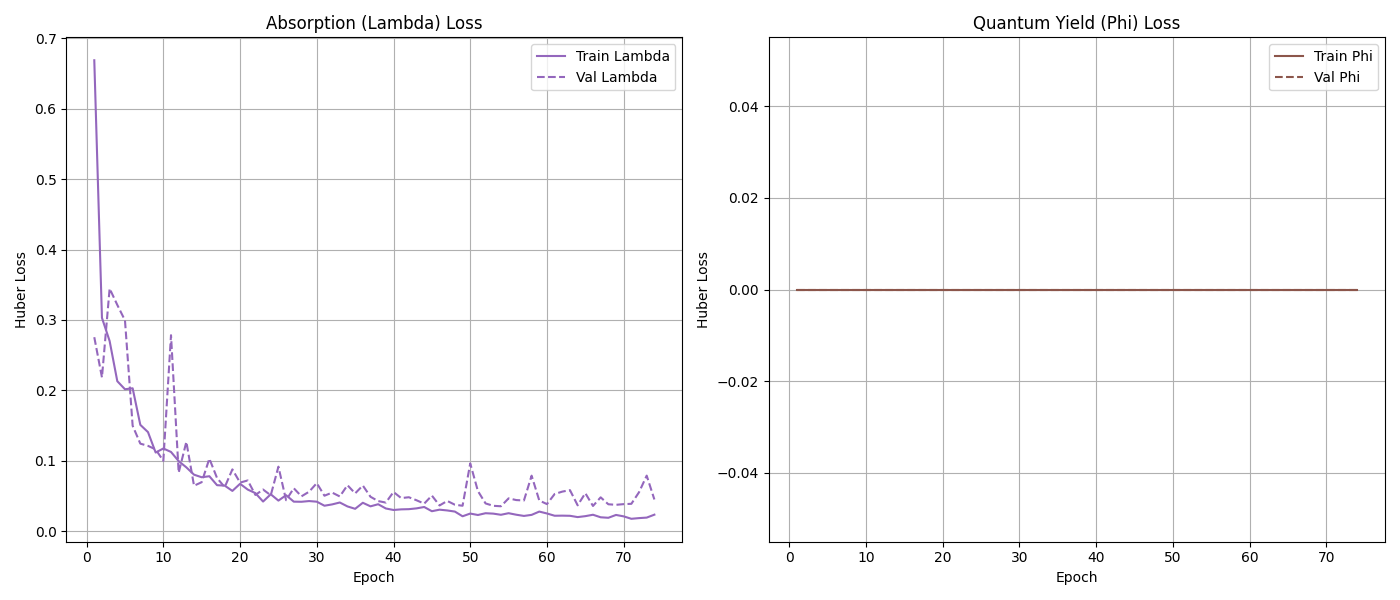

Fluorescence Training Loss Curves:


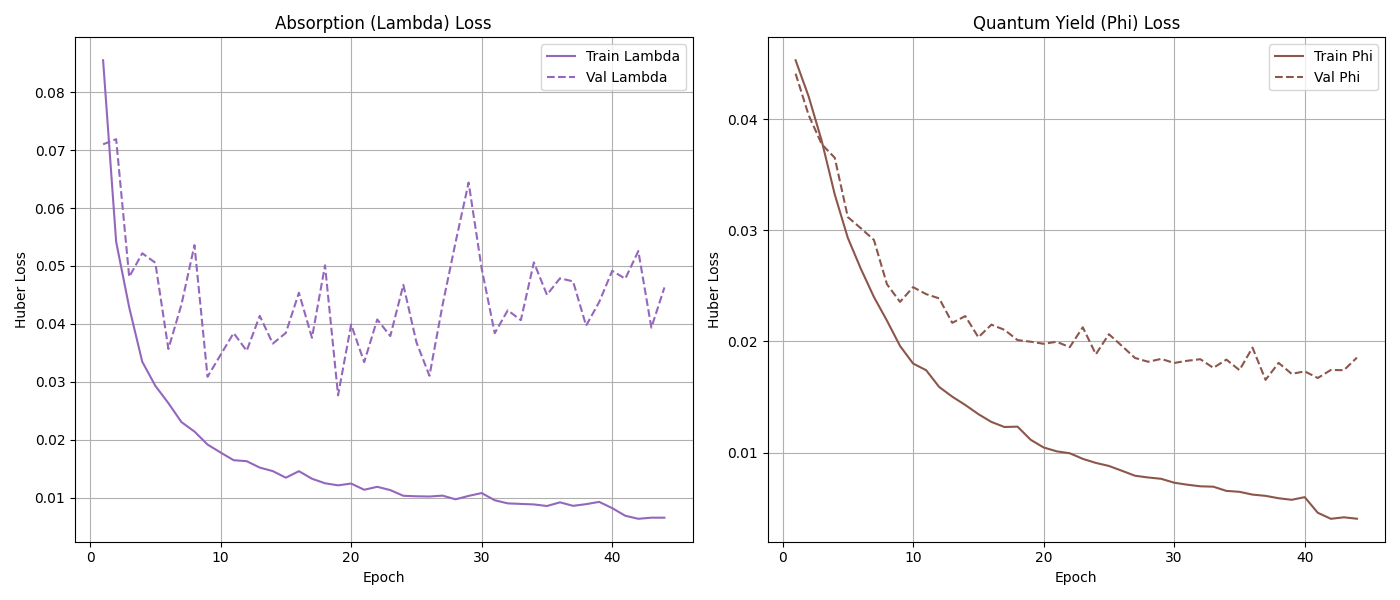


Phi Training Loss Curves:


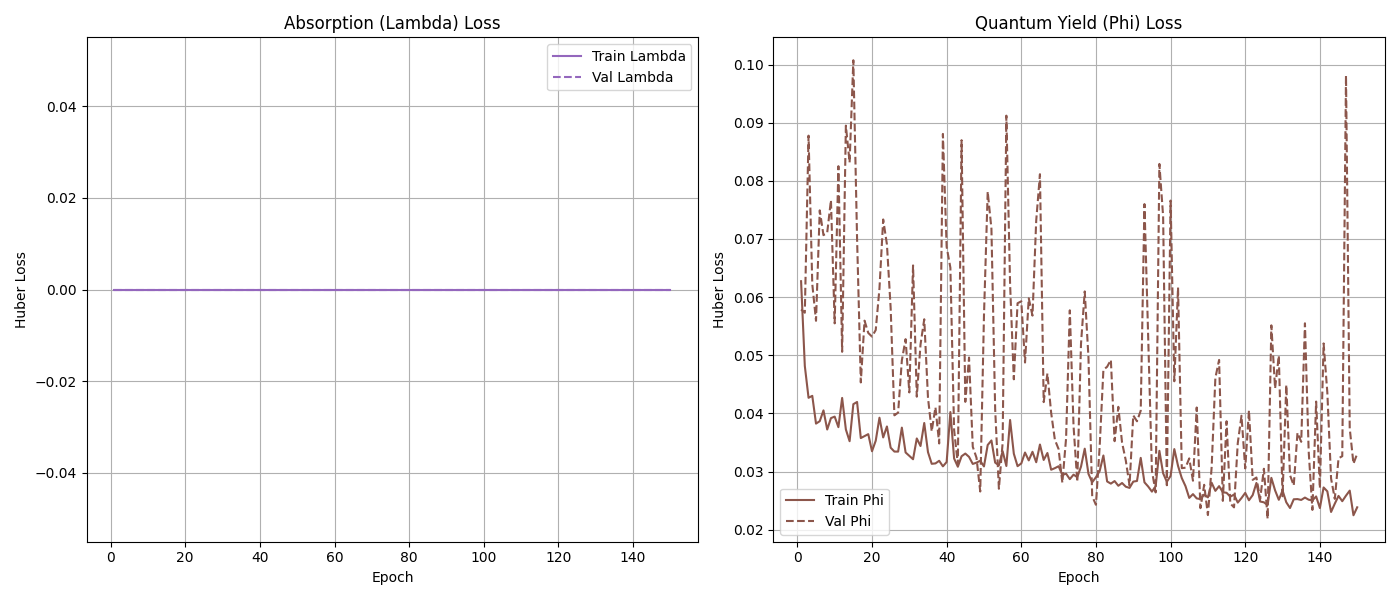

In [ ]:
# Display loss curves if they exist
from IPython.display import Image, display

lambda_curves = SAVE_DIR_LAMBDA / "loss_curves.png"
fluor_curves = SAVE_DIR_FLUOR / "loss_curves.png"
phi_curves = SAVE_DIR_PHI / "loss_curves.png"

if lambda_curves.exists():
    print("Lambda Training Loss Curves:")
    display(Image(filename=str(lambda_curves)))

if fluor_curves.exists():
    print("Fluorescence Training Loss Curves:")
    display(Image(filename=str(fluor_curves)))

if phi_curves.exists():
    print("\nPhi Training Loss Curves:")
    display(Image(filename=str(phi_curves)))